# NHANES project about General Oral Health: descriptive and regression analysis
> This notebook has the purpose to collect all the analysis on Nhanes dataset for a medical paper project 

Requirements and Information:
1. Nhanes dataset from 2009/10 to 2013/14
2. 5 Intrinsic Capacity domains
    1. Locomotion:
        - Standingup from armless chair difficulty (PFQ061I)
    2. Cognitive Function:
        - Have serious difficulty concentrating (DLQ040)
    3. Vitality:
        - Weight change intentional (WHQ060)
        - Poor appetite or overeating (DPQ050)
    4. Psychological status:
        - Feeling down, depressed, or hopeless (DPQ020)
        - Have little interest in doing things (DPQ010)
    5. Sensory domain:
        - Have serious difficulty hearing? (DLQ010)
        - Have serious difficulty seeing? (DLQ020)
3. Exposure/Predictor:
    1. OHQ835 : {Do you/Does SP} think {you/s/he} might have gum disease?
    2. OHQ845 : Overall, how would {you/SP} rate the health of {your/his/her} teeth and gums?
    3. OHQ850 : Ever had treatment for gum disease?
    4. OHQ855 : Any teeth became loose without an injury
    5. OHQ860 : Ever been told of bone loss around teeth
    6. OHQ865 : Noticed a tooth that doesn't look right
    7. OHQ870 : How many days use dental floss/device
    8. OHQ875 : Days used mouthwash for dental problem
4. Confounding Variables:
    - Gender (RIAGENDR)
    - Age at screening (RIDAGEYR)
    - Race (RIDRETH1)
    - Education	(DMDEDUC2)
    - Poverty income ratio (INDFMPIR)
    - Smoking status (SMQ020)
5. Mediators:
    - Heart failure	(RIDRETH1)  
    - Coronary heart disease (MCQ160b)
    - Stroke (MCQ160c)
    - Liver disease	(MCQ160o)
    - Cancer (MCQ500)
    - Diabetes (MCQ220)
    - High blood pressure (DIQ010)
6. Age => 60

## NHANES 2013/14: Intrinsic Capacity and Global Oral Health

### Import Libraries

In [1]:
library(haven)
library(nhanesA)
library(survey)
library(MASS)
library(dplyr)
library(tidyr)
library(tidyverse)
library(ggplot2)
library(readr)
library(flextable)
library(officer)
library(nnet)
library(broom)
library(ggplot2)

Loading required package: grid

Loading required package: Matrix

Loading required package: survival


Attaching package: 'survey'


The following object is masked from 'package:graphics':

    dotchart



Attaching package: 'dplyr'


The following object is masked from 'package:MASS':

    select


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union



Attaching package: 'tidyr'


The following objects are masked from 'package:Matrix':

    expand, pack, unpack


-- Attaching core tidyverse packages ------------------------ tidyverse 2.0.0 --
v forcats   1.0.0     v readr     2.1.5
v ggplot2   3.5.1     v stringr   1.5.1
v lubridate 1.9.4     v tibble    3.2.1
v purrr     1.0.2     
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x tidyr::expand() masks Matrix::expand()
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stat

### Configurations

In [3]:
path_to_data_09_10 <- "/Users/silvanoquarto/Desktop/LAVORO/MEDICAL_PHYSICS/Med-Physics/data/NHANES/2009_10/"
path_to_data_11_12 <- "/Users/silvanoquarto/Desktop/LAVORO/MEDICAL_PHYSICS/Med-Physics/data/NHANES/2011_12/"
path_to_data_13_14 <- "/Users/silvanoquarto/Desktop/LAVORO/MEDICAL_PHYSICS/Med-Physics/data/NHANES/2013_14/"

### Load Dataset & Feature Selection

In [30]:
# Datasets for 2009/10 period

demo_09_10 <- read_xpt(file.path(path_to_data_09_10, "DEMO_F.xpt"))

demo_09_10_selected <- demo_09_10 %>%
  select(SEQN, RIAGENDR, RIDAGEYR, RIDRETH1, DMDEDUC2, INDFMPIR)

alcohol_09_10 <- read_xpt(file.path(path_to_data_09_10, "ALQ_F.xpt"))

alcohol_09_10_selected <- alcohol_09_10 %>%
  select(SEQN, ALQ101)

smoking_09_10 <- read_xpt(file.path(path_to_data_09_10, "SMQ_F.xpt.txt"))

smoking_09_10_selected <- smoking_09_10 %>%
    select(SEQN, SMQ020)

med_conditions_09_10 <- read_xpt(file.path(path_to_data_09_10, "MCQ_F.xpt"))

med_conditions_09_10_selected <- med_conditions_09_10 %>%
    select(SEQN, MCQ140, MCQ160B, MCQ160C, MCQ160D, MCQ160E, MCQ160F, MCQ160L, MCQ220)

med_conditions_09_10_selected <- med_conditions_09_10_selected %>%
  rename(DLQ020 = MCQ140)


blood_pressure_09_10 <- read_xpt(file.path(path_to_data_09_10, "BPQ_F.xpt"))

blood_pressure_09_10_selected <- blood_pressure_09_10 %>%
    select(SEQN, BPQ020)


diabetes_09_10 <- read_xpt(file.path(path_to_data_09_10, "DIQ_F.xpt"))

diabetes_09_10_selected <- diabetes_09_10 %>%
    select(SEQN, DIQ010)


oral_09_10 <- read_xpt(file.path(path_to_data_09_10, "OHQ_F.xpt"))

selected_cols <- c(
  "OHQ835",
  "OHQ845",
  "OHQ850",
  "OHQ855",
  "OHQ860",
  "OHQ865",
  "OHQ870",
  "OHQ875"
)
oral_09_10_selected <- oral_09_10 %>%
    select(SEQN, all_of(selected_cols))


locomotion_09_10 <- read_xpt(file.path(path_to_data_09_10, "PFQ_F.xpt"))

locomotion_09_10_selected <- locomotion_09_10 %>%
    select(SEQN, PFQ061I)


mental_health_09_10 <- read_xpt(file.path(path_to_data_09_10, "DPQ_F.xpt"))

mental_health_09_10_selected <- mental_health_09_10 %>%
    select(SEQN, DPQ010, DPQ020, DPQ050, DPQ070)

mental_health_09_10_selected <- mental_health_09_10_selected %>%
  mutate(DPQ070 = case_when(
    DPQ070 %in% c(0, 1) ~ 2,
    DPQ070 %in% c(2, 3) ~ 1,
    TRUE ~ DPQ070
  ))

mental_health_09_10_selected <- mental_health_09_10_selected %>%
  rename(DLQ040 = DPQ070)


weight_history_09_10 <- read_xpt(file.path(path_to_data_09_10, "WHQ_F.xpt"))

weight_history_09_10_selected <- weight_history_09_10 %>%
    select(SEQN, WHQ060)


audiometry_09_10 <- read_xpt(file.path(path_to_data_09_10, "AUQ_F.xpt"))

audiometry_09_10_selected <- audiometry_09_10 %>%
    select(SEQN, AUQ131)

audiometry_09_10_selected <- audiometry_09_10_selected %>%
  mutate(AUQ131 = case_when(
    AUQ131 %in% c(1, 2, 3) ~ 2,
    AUQ131 %in% c(4, 5, 6) ~ 1,
    TRUE ~ AUQ131
  ))

audiometry_09_10_selected <- audiometry_09_10_selected %>%
  rename(DLQ010 = AUQ131)

In [31]:
# Datasets for 2011/12 period

demo_11_12 <- read_xpt(file.path(path_to_data_11_12, "DEMO_G.xpt.txt"))

demo_11_12_selected <- demo_11_12 %>%
  select(SEQN, RIAGENDR, RIDAGEYR, RIDRETH1, DMDEDUC2, INDFMPIR)

alcohol_11_12 <- read_xpt(file.path(path_to_data_11_12, "ALQ_G.xpt.txt"))

alcohol_11_12_selected <- alcohol_11_12 %>%
  select(SEQN, ALQ101)


smoking_11_12 <- read_xpt(file.path(path_to_data_11_12, "SMQ_G.xpt.txt"))

smoking_11_12_selected <- smoking_11_12 %>%
    select(SEQN, SMQ020)


med_conditions_11_12 <- read_xpt(file.path(path_to_data_11_12, "MCQ_G.xpt.txt"))

med_conditions_11_12_selected <- med_conditions_11_12 %>%
    select(SEQN, MCQ140, MCQ160B, MCQ160C, MCQ160D, MCQ160E, MCQ160F, MCQ160L, MCQ220)

med_conditions_11_12_selected <- med_conditions_11_12_selected %>%
  rename(DLQ020 = MCQ140)


blood_pressure_11_12 <- read_xpt(file.path(path_to_data_11_12, "BPQ_G.xpt.txt"))

blood_pressure_11_12_selected <- blood_pressure_11_12 %>%
    select(SEQN, BPQ020)


diabetes_11_12 <- read_xpt(file.path(path_to_data_11_12, "DIQ_G.xpt.txt"))

diabetes_11_12_selected <- diabetes_11_12 %>%
    select(SEQN, DIQ010)


oral_11_12 <- read_xpt(file.path(path_to_data_11_12, "OHQ_G.xpt.txt"))

selected_cols <- c(
  "OHQ835",
  "OHQ845",
  "OHQ850",
  "OHQ855",
  "OHQ860",
  "OHQ865",
  "OHQ870",
  "OHQ875"
)
oral_11_12_selected <- oral_11_12 %>%
    select(SEQN, all_of(selected_cols))

locomotion_11_12 <- read_xpt(file.path(path_to_data_11_12, "PFQ_G.xpt.txt"))

locomotion_11_12_selected <- locomotion_11_12 %>%
    select(SEQN, PFQ061I)


mental_health_11_12 <- read_xpt(file.path(path_to_data_11_12, "DPQ_G.xpt.txt"))

mental_health_11_12_selected <- mental_health_11_12 %>%
    select(SEQN, DPQ010, DPQ020, DPQ050, DPQ070)

mental_health_11_12_selected <- mental_health_11_12_selected %>%
  mutate(DPQ070 = case_when(
    DPQ070 %in% c(0, 1) ~ 2,
    DPQ070 %in% c(2, 3) ~ 1,
    TRUE ~ DPQ070
  ))

mental_health_11_12_selected <- mental_health_11_12_selected %>%
  rename(DLQ040 = DPQ070)


weight_history_11_12 <- read_xpt(file.path(path_to_data_11_12, "WHQ_G.xpt.txt"))

weight_history_11_12_selected <- weight_history_11_12 %>%
    select(SEQN, WHQ060)


audiometry_11_12 <- read_xpt(file.path(path_to_data_11_12, "AUQ_G.xpt.txt"))

audiometry_11_12_selected <- audiometry_11_12 %>%
  select(SEQN, AUQ054)

audiometry_11_12_selected <- audiometry_11_12_selected %>%
  mutate(AUQ054 = case_when(
    AUQ054 %in% c(1, 2, 3) ~ 2,
    AUQ054 %in% c(4, 5, 6) ~ 1,
    TRUE ~ AUQ054
  ))

audiometry_11_12_selected <- audiometry_11_12_selected %>%
  rename(DLQ010 = AUQ054)

In [32]:
# Datasets for 2013/14 period

demo_13_14 <- read_xpt(file.path(path_to_data_13_14, "DEMO_H.xpt.txt"))

demo_13_14_selected <- demo_13_14 %>%
    select(SEQN, RIAGENDR, RIDAGEYR, RIDRETH1, DMDEDUC2, INDFMPIR)


alcohol_13_14 <- read_xpt(file.path(path_to_data_13_14, "ALQ_H.xpt.txt"))

alcohol_13_14_selected <- alcohol_13_14 %>%
    select(SEQN, ALQ101)


smoking_13_14 <- read_xpt(file.path(path_to_data_13_14, "SMQ_H.xpt.txt"))

smoking_13_14_selected <- smoking_13_14 %>%
    select(SEQN, SMQ020)


med_conditions_13_14 <- read_xpt(file.path(path_to_data_13_14, "MCQ_H.xpt.txt"))

med_conditions_13_14_selected <- med_conditions_13_14 %>%
    select(SEQN, MCQ160B, MCQ160C, MCQ160D, MCQ160E, MCQ160F, MCQ160L, MCQ220)


blood_pressure_13_14 <- read_xpt(file.path(path_to_data_13_14, "BPQ_H.xpt.txt"))

blood_pressure_13_14_selected <- blood_pressure_13_14 %>%
    select(SEQN, BPQ020)


diabetes_13_14 <- read_xpt(file.path(path_to_data_13_14, "DIQ_H.xpt.txt"))

diabetes_13_14_selected <- diabetes_13_14 %>%
    select(SEQN, DIQ010)


oral_13_14 <- read_xpt(file.path(path_to_data_13_14, "OHQ_H.xpt.txt"))

selected_cols <- c(
  "OHQ835",
  "OHQ845",
  "OHQ850",
  "OHQ855",
  "OHQ860",
  "OHQ865",
  "OHQ870",
  "OHQ875"
)
oral_13_14_selected <- oral_13_14 %>%
  select(SEQN, all_of(selected_cols))


locomotion_13_14 <- read_xpt(file.path(path_to_data_13_14, "PFQ061I.txt"))

locomotion_13_14_selected <- locomotion_13_14 %>%
    select(SEQN, PFQ061I)


disability_13_14 <- read_xpt(file.path(path_to_data_13_14, "DLQ040.txt"))

disability_13_14_selected <- disability_13_14 %>%
    select(SEQN, DLQ010, DLQ020, DLQ040)


mental_health_13_14 <- read_xpt(file.path(path_to_data_13_14, "DPQ-.txt"))

mental_health_13_14_selected <- mental_health_13_14 %>%
    select(SEQN, DPQ010, DPQ020, DPQ050)


weight_history_13_14 <- read_xpt(file.path(path_to_data_13_14, "WHQ060.txt"))

weight_history_13_14_selected <- weight_history_13_14 %>%
    select(SEQN, WHQ060)

In [33]:
dim(oral_09_10_selected)
dim(oral_11_12_selected)
dim(oral_13_14_selected)

[1] 5177    9

[1] 9364    9

[1] 9770    9

### Merge datasets without NA and missing values
> Merge all data from each datasets and then exclude patients

In [34]:
# Merge datasets demographics and intrinsic capacity data

datasets_09_10 <- list(
  demo_09_10_selected, alcohol_09_10_selected, smoking_09_10_selected, med_conditions_09_10_selected,
  blood_pressure_09_10_selected, diabetes_09_10_selected,
  locomotion_09_10_selected, mental_health_09_10_selected,
  weight_history_09_10_selected, audiometry_09_10_selected, oral_09_10_selected
)

datasets_11_12 <- list(
  demo_11_12_selected, alcohol_11_12_selected, smoking_11_12_selected, med_conditions_11_12_selected,
  blood_pressure_11_12_selected, diabetes_11_12_selected,
  locomotion_11_12_selected, mental_health_11_12_selected,
  weight_history_11_12_selected, audiometry_11_12_selected, oral_11_12_selected
)

datasets_13_14 <- list(
  demo_13_14_selected, alcohol_13_14_selected, smoking_13_14_selected, med_conditions_13_14_selected,
  blood_pressure_13_14_selected, diabetes_13_14_selected,
  locomotion_13_14_selected, disability_13_14_selected, mental_health_13_14_selected,
  weight_history_13_14_selected, oral_13_14_selected
)

# Horizontal union for period 2009/10, 2011/12, 2013/14

df_09_10 <- Reduce(function(x, y) full_join(x, y, by = "SEQN"), datasets_09_10)

df_11_12 <- Reduce(function(x, y) full_join(x, y, by = "SEQN"), datasets_11_12)

df_13_14 <- Reduce(function(x, y) full_join(x, y, by = "SEQN"), datasets_13_14)

# Vertical union

df_final <- bind_rows(df_09_10, df_11_12, df_13_14)

print("Dimensions before removing NA values")
dim(df_final)

# Filter with AGE >= 60

df_final_age_60 <- subset(df_final, RIDAGEYR >= 60)

print("Dimensions with AGE >= 60")
dim(df_final_age_60)

# Excluding patients with missing values in Intrinsic Capacity features

df_final_excluding_IC <- df_final_age_60[complete.cases(df_final_age_60[, c('DLQ020', 'PFQ061I', 'DPQ010', 'DPQ020', 'DPQ050', 'DLQ040', 'WHQ060', 'DLQ010')]), ]

df_final_excluding_IC <- df_final_excluding_IC %>%
  filter(!if_any(c(DLQ020, PFQ061I, DLQ040, WHQ060, DLQ010,
                   DPQ020, DPQ050, DPQ010), ~ . == 9))

df_final_excluding_IC <- df_final_excluding_IC %>%
  filter(!if_any(c(DLQ020, PFQ061I, DLQ040, WHQ060, DLQ010,
                   DPQ020, DPQ050, DPQ010), ~ . == 7))

df_final_excluding_IC <- df_final_excluding_IC %>%
  filter(!if_any(c(DLQ020, PFQ061I, DLQ040, WHQ060, DLQ010,
                   DPQ020, DPQ050, DPQ010), ~ . == 99))

print("Dimensions without IC missing values")
dim(df_final_excluding_IC)

# Excluding patients with no examinations for Oral examination

df_final_excluding_oral <- df_final_excluding_IC[complete.cases(
  df_final_excluding_IC[, c(
                            "OHQ835",
                            "OHQ845",
                            "OHQ850",
                            "OHQ855",
                            "OHQ860",
                            "OHQ865",
                            "OHQ870",
                            "OHQ875"
                          )]), ]

df_final_excluding_oral <- df_final_excluding_oral %>%
  filter(!if_any(c(OHQ835, OHQ845, OHQ850, OHQ855, OHQ860,
                   OHQ865, OHQ870, OHQ875), ~ . == 9))

df_final_excluding_oral <- df_final_excluding_oral %>%
  filter(!if_any(c(OHQ835, OHQ845, OHQ850, OHQ855, OHQ860,
                   OHQ865), ~ . == 7))

df_final_excluding_oral <- df_final_excluding_oral %>%
  filter(!if_any(c(OHQ870, OHQ875), ~ . == 77))

df_final_excluding_oral <- df_final_excluding_oral %>%
  filter(!if_any(c(OHQ870, OHQ875), ~ . == 99))

print("Dimensions without complete Oral examination (missing values)")
dim(df_final_excluding_oral)

# Excluding patients with missing values in Confounding features

df_final_excluding_confounding <- df_final_excluding_oral[complete.cases(df_final_excluding_oral[, 
                                  c('RIAGENDR', 'RIDAGEYR', 'RIDRETH1', 'DMDEDUC2', 'INDFMPIR', 'ALQ101', 'SMQ020', 'MCQ160B',
                                  'MCQ160C', 'MCQ160D', 'MCQ160E', 'MCQ160F', 'MCQ160L', 'MCQ220', 'BPQ020', 'DIQ010')]), ]

df_final_merged <- df_final_excluding_confounding %>%
  filter(!if_any(c(DMDEDUC2, ALQ101, MCQ160B, MCQ160C, MCQ160D,
                   MCQ160E, MCQ160F, MCQ160L, BPQ020, DIQ010), ~ . == 9))

print("Dimensions without Confounding missing values")
dim(df_final_merged)

[1] "Dimensions before removing NA values"


[1] 30468    33

[1] "Dimensions with AGE >= 60"


[1] 5705   33

[1] "Dimensions without IC missing values"


[1] 994  33

[1] "Dimensions without complete Oral examination (missing values)"


[1] 928  33

[1] "Dimensions without Confounding missing values"


[1] 828  33

In [37]:
# Saving preprocessed

write.csv(df_final_merged, "/Users/silvanoquarto/Desktop/LAVORO/MEDICAL_PHYSICS/Med-Physics/data/NHANES/df_oral_health_09_14.csv", row.names=FALSE)

### Exploratory Analysis

In [4]:
df <- read.csv("/Users/silvanoquarto/Desktop/LAVORO/MEDICAL_PHYSICS/Med-Physics/data/NHANES/df_oral_health_09_14.csv", 
              stringsAsFactors = TRUE)

head(df)

,SEQN,RIAGENDR,RIDAGEYR,RIDRETH1,DMDEDUC2,INDFMPIR,ALQ101,SMQ020,DLQ020,MCQ160B,...,WHQ060,DLQ010,OHQ835,OHQ845,OHQ850,OHQ855,OHQ860,OHQ865,OHQ870,OHQ875
,<int>,<int>,<int>,<int>,<int>,<dbl>,<int>,<int>,<int>,<int>,...,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,51633,1,80,3,4,1.27,1,1,1,2,...,1,2,2,2,2,2,2,2,5,6
2,51654,1,66,3,4,2.20,1,1,2,2,...,2,2,2,2,1,2,1,2,7,7
3,51680,2,60,4,4,2.59,1,1,1,2,...,1,2,2,3,2,2,1,1,7,0
4,51687,1,78,3,5,5.00,1,1,2,2,...,2,2,2,3,2,2,2,2,7,0
5,51736,2,60,1,3,0.68,1,1,2,2,...,1,2,2,2,2,2,2,2,4,6
6,51861,1,80,3,3,4.94,1,2,2,2,...,1,1,2,2,2,1,2,2,0,7


In [ ]:
# Import libraries

library(tidyverse)
library(corrplot)
library(ggplot2)
library(gridExtra)
library(psych)
library(tidyverse)
library(cluster)    # PAM, clara, daisy
library(factoextra)
library(clustMixType) # k-prototypes
library(NbClust)     
library(klaR)        # kmodes
library(ClustOfVar)  
library(fpc)
#library(summarytools)
#library(RColorBrewer)

#### Exploring the distributions of individual oral health variables

In [6]:
oral_vars <- c("OHQ835", "OHQ845", "OHQ850", "OHQ855", 
               "OHQ860", "OHQ865", "OHQ870", "OHQ875")

df_oral <- df[, oral_vars]

# Statistics information
cat("Df Shape: ", dim(df_oral), "\n", "\n")
print(summary(df_oral))

Df Shape:  828 8 
 
     OHQ835          OHQ845          OHQ850          OHQ855          OHQ860    
 Min.   :1.000   Min.   :1.000   Min.   :1.000   Min.   :1.000   Min.   :1.00  
 1st Qu.:2.000   1st Qu.:2.000   1st Qu.:1.000   1st Qu.:2.000   1st Qu.:2.00  
 Median :2.000   Median :3.000   Median :2.000   Median :2.000   Median :2.00  
 Mean   :1.838   Mean   :3.098   Mean   :1.745   Mean   :1.768   Mean   :1.82  
 3rd Qu.:2.000   3rd Qu.:4.000   3rd Qu.:2.000   3rd Qu.:2.000   3rd Qu.:2.00  
 Max.   :2.000   Max.   :5.000   Max.   :2.000   Max.   :2.000   Max.   :2.00  
     OHQ865          OHQ870         OHQ875     
 Min.   :1.000   Min.   :0.00   Min.   :0.000  
 1st Qu.:2.000   1st Qu.:0.00   1st Qu.:0.000  
 Median :2.000   Median :1.00   Median :3.000  
 Mean   :1.819   Mean   :2.68   Mean   :3.301  
 3rd Qu.:2.000   3rd Qu.:7.00   3rd Qu.:7.000  
 Max.   :2.000   Max.   :7.00   Max.   :7.000  


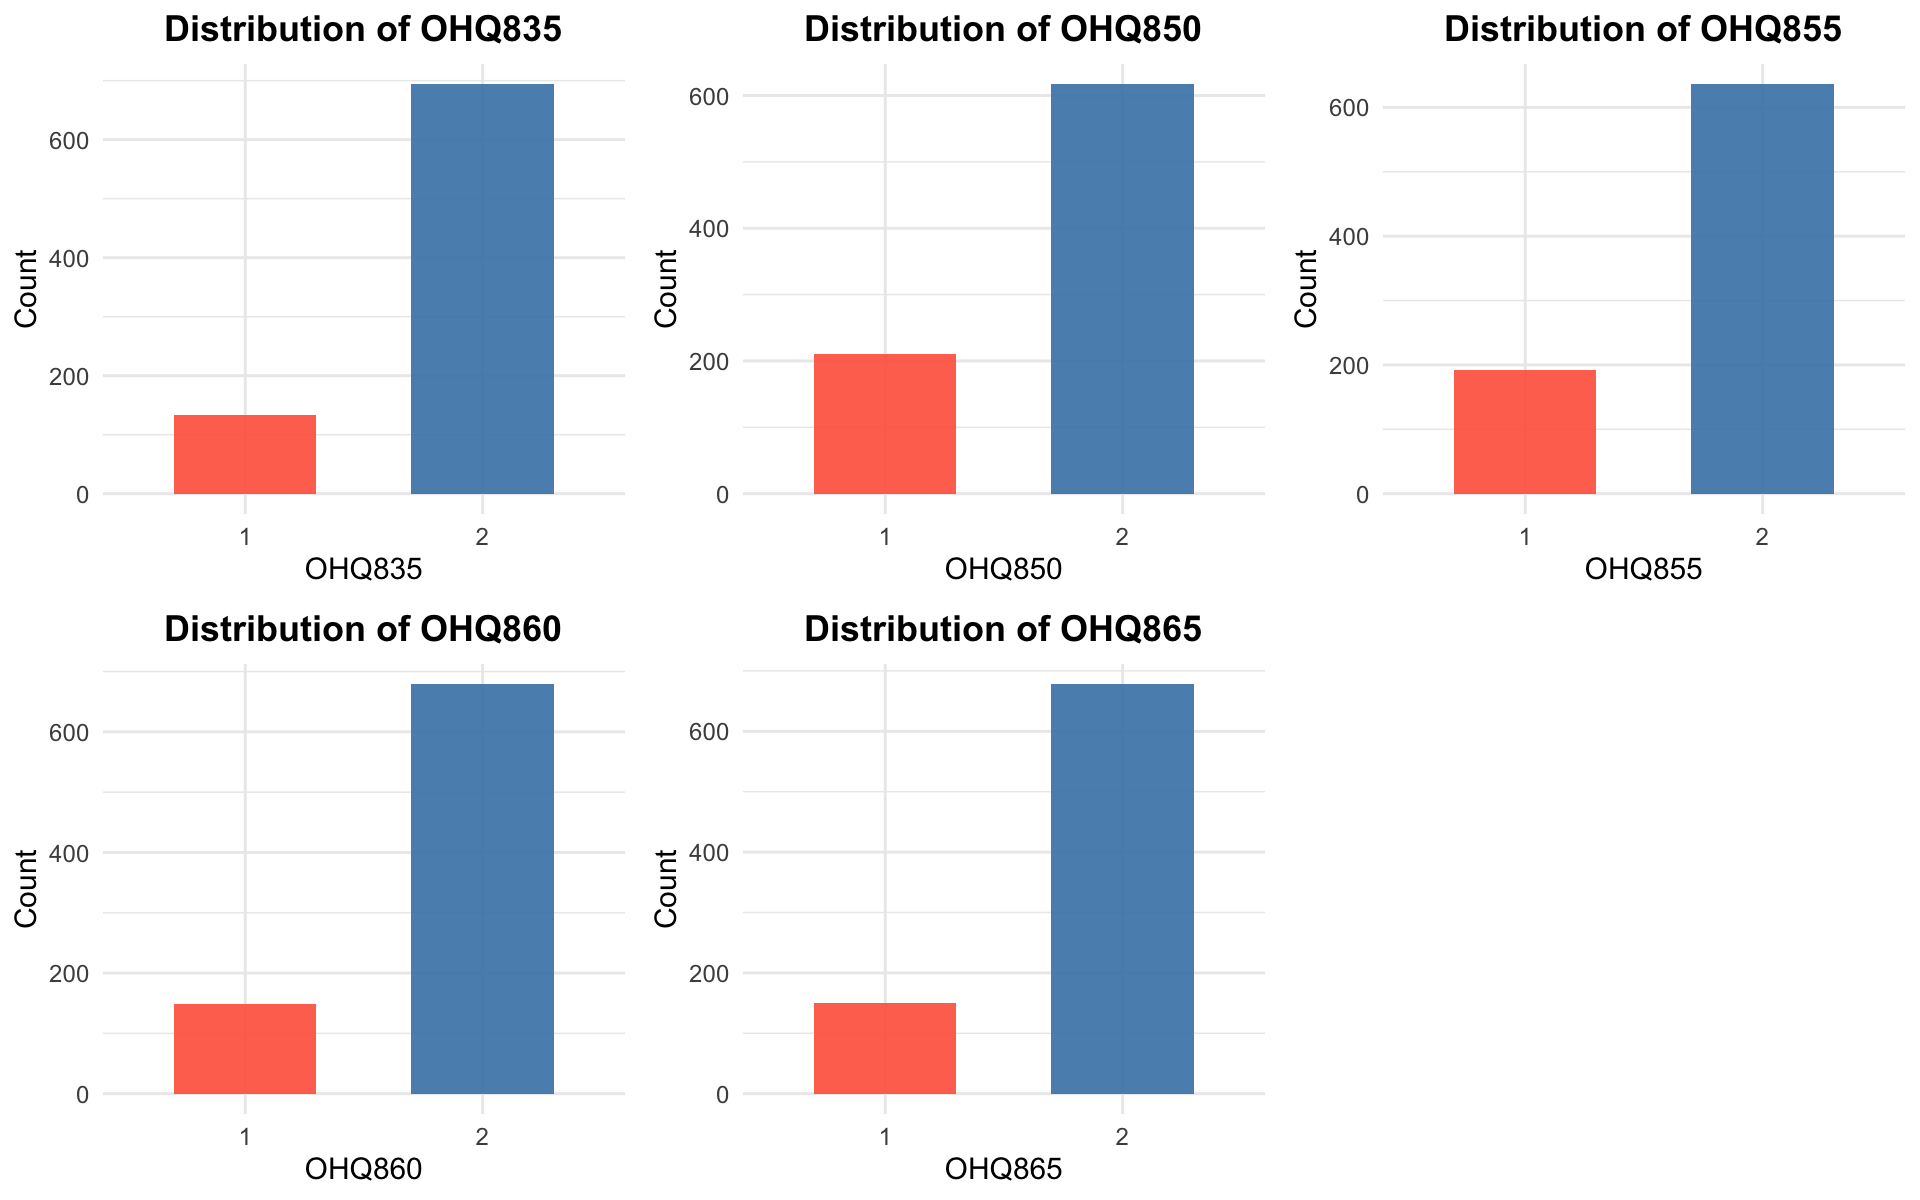

In [69]:
# Barplot for binary variables

options(repr.plot.width = 16, repr.plot.height = 10)

binary_vars <- c("OHQ835", "OHQ850", "OHQ855", "OHQ860", "OHQ865")
df_oral[binary_vars] <- lapply(df_oral[binary_vars], as.factor)
plots_binary <- list()

for (var in binary_vars) {
    p <- ggplot(df_oral, aes_string(x = var, fill = var)) +
        geom_bar(alpha = 0.9, width = 0.6) +
        scale_fill_manual(values = c("tomato", "steelblue")) +
        labs(title = paste("Distribution of", var),
             x = var,
             y = "Count") +
        theme_minimal(base_size = 18) +
        theme(
            plot.title = element_text(hjust = 0.5, face = "bold"),
            legend.position = "none"
        )
    plots_binary[[var]] <- p
}

do.call(grid.arrange, c(plots_binary, ncol = 3))

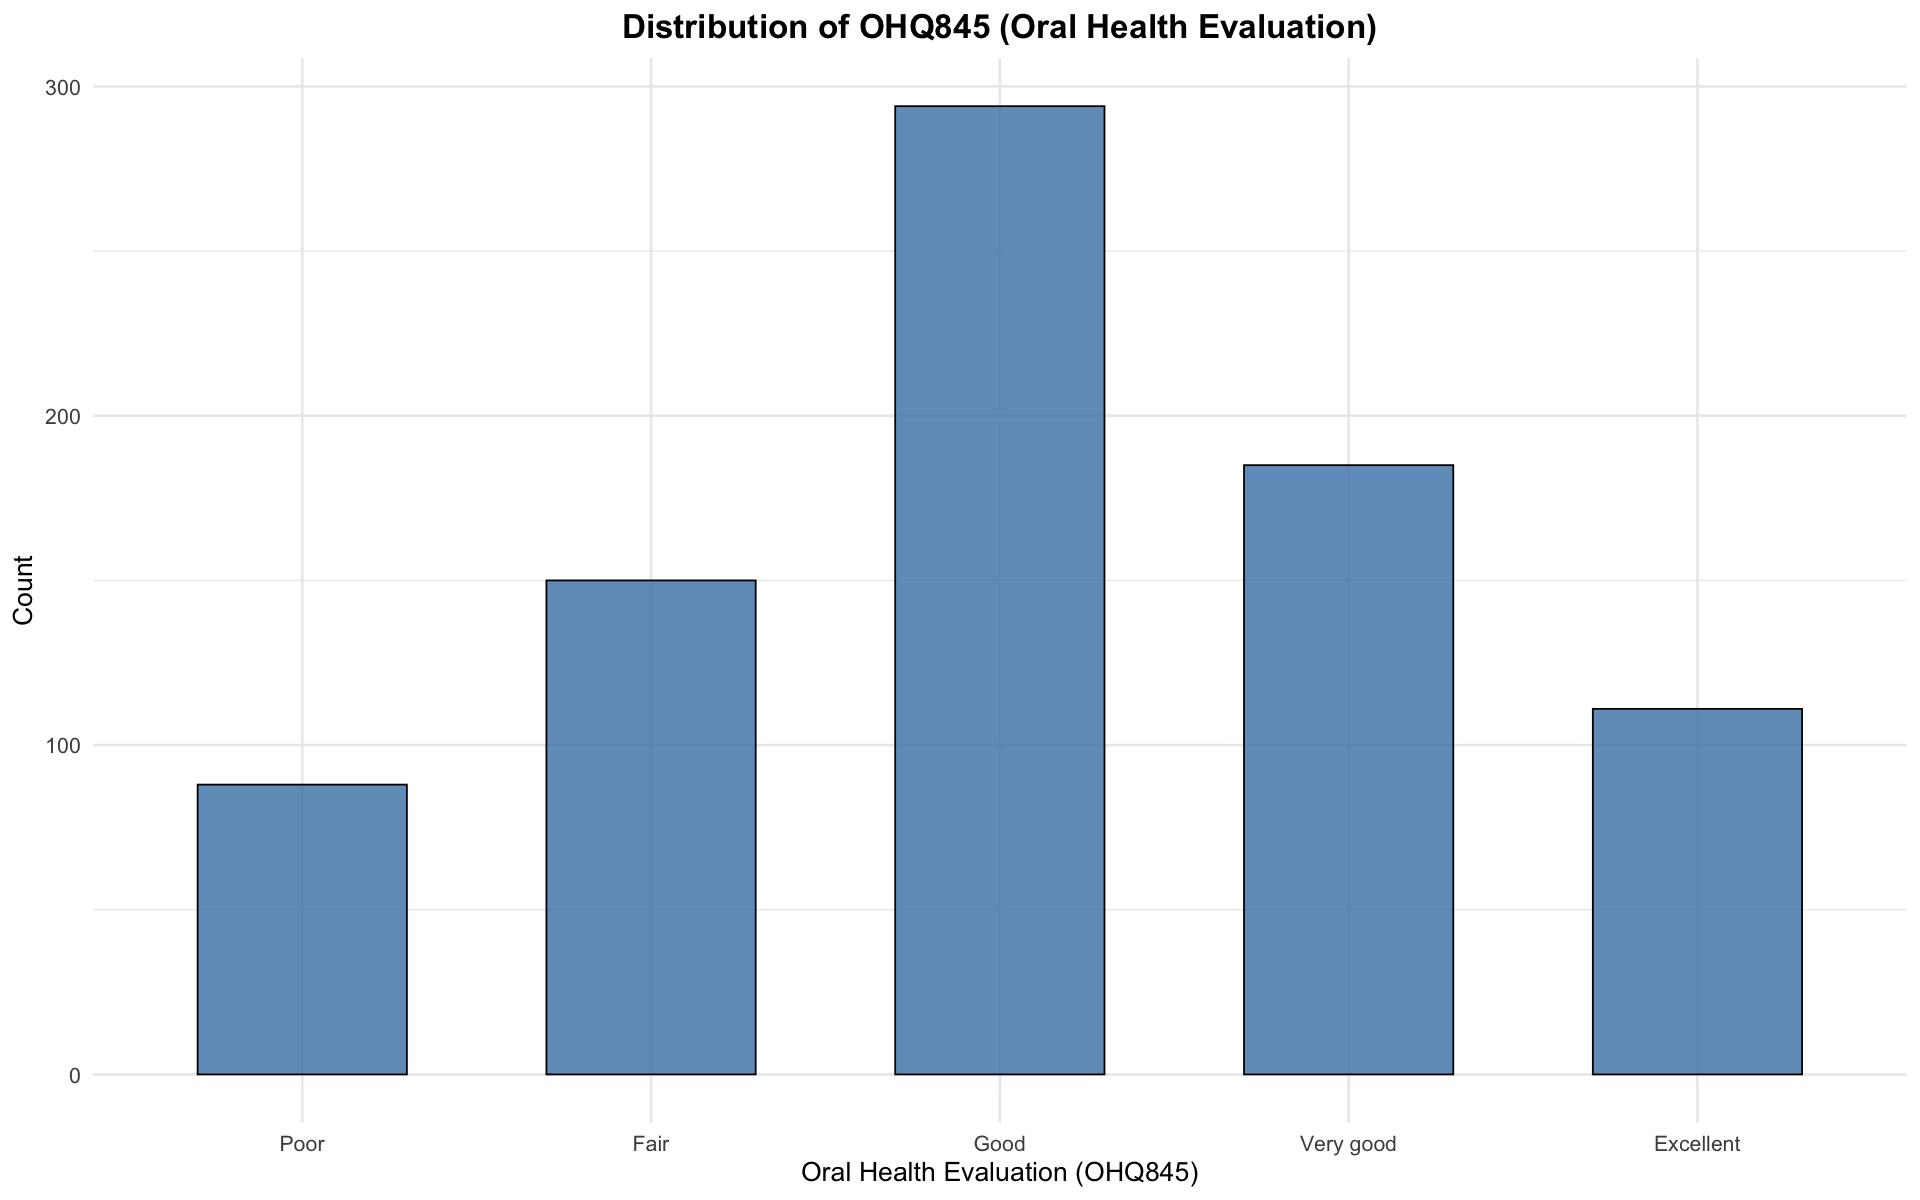

In [70]:
# Barplot for ordinal variables (OHQ845)

df_oral$OHQ845 <- factor(df_oral$OHQ845, 
                         levels = c(1,2,3,4,5),
                         labels = c("Poor", "Fair", "Good", "Very good", "Excellent"),
                         ordered = TRUE)

p_ordinal <- ggplot(df_oral, aes_string(x = "OHQ845")) +
  geom_bar(fill = "steelblue", color = "black", alpha = 0.8, width = 0.6) +
  labs(
    title = "Distribution of OHQ845 (Oral Health Evaluation)",
    x = "Oral Health Evaluation (OHQ845)",
    y = "Count"
  ) +
  theme_minimal(base_size = 16) +
  theme(
    plot.title = element_text(hjust = 0.5, face = "bold", size = 20),
    legend.position = "none"
  )

print(p_ordinal)

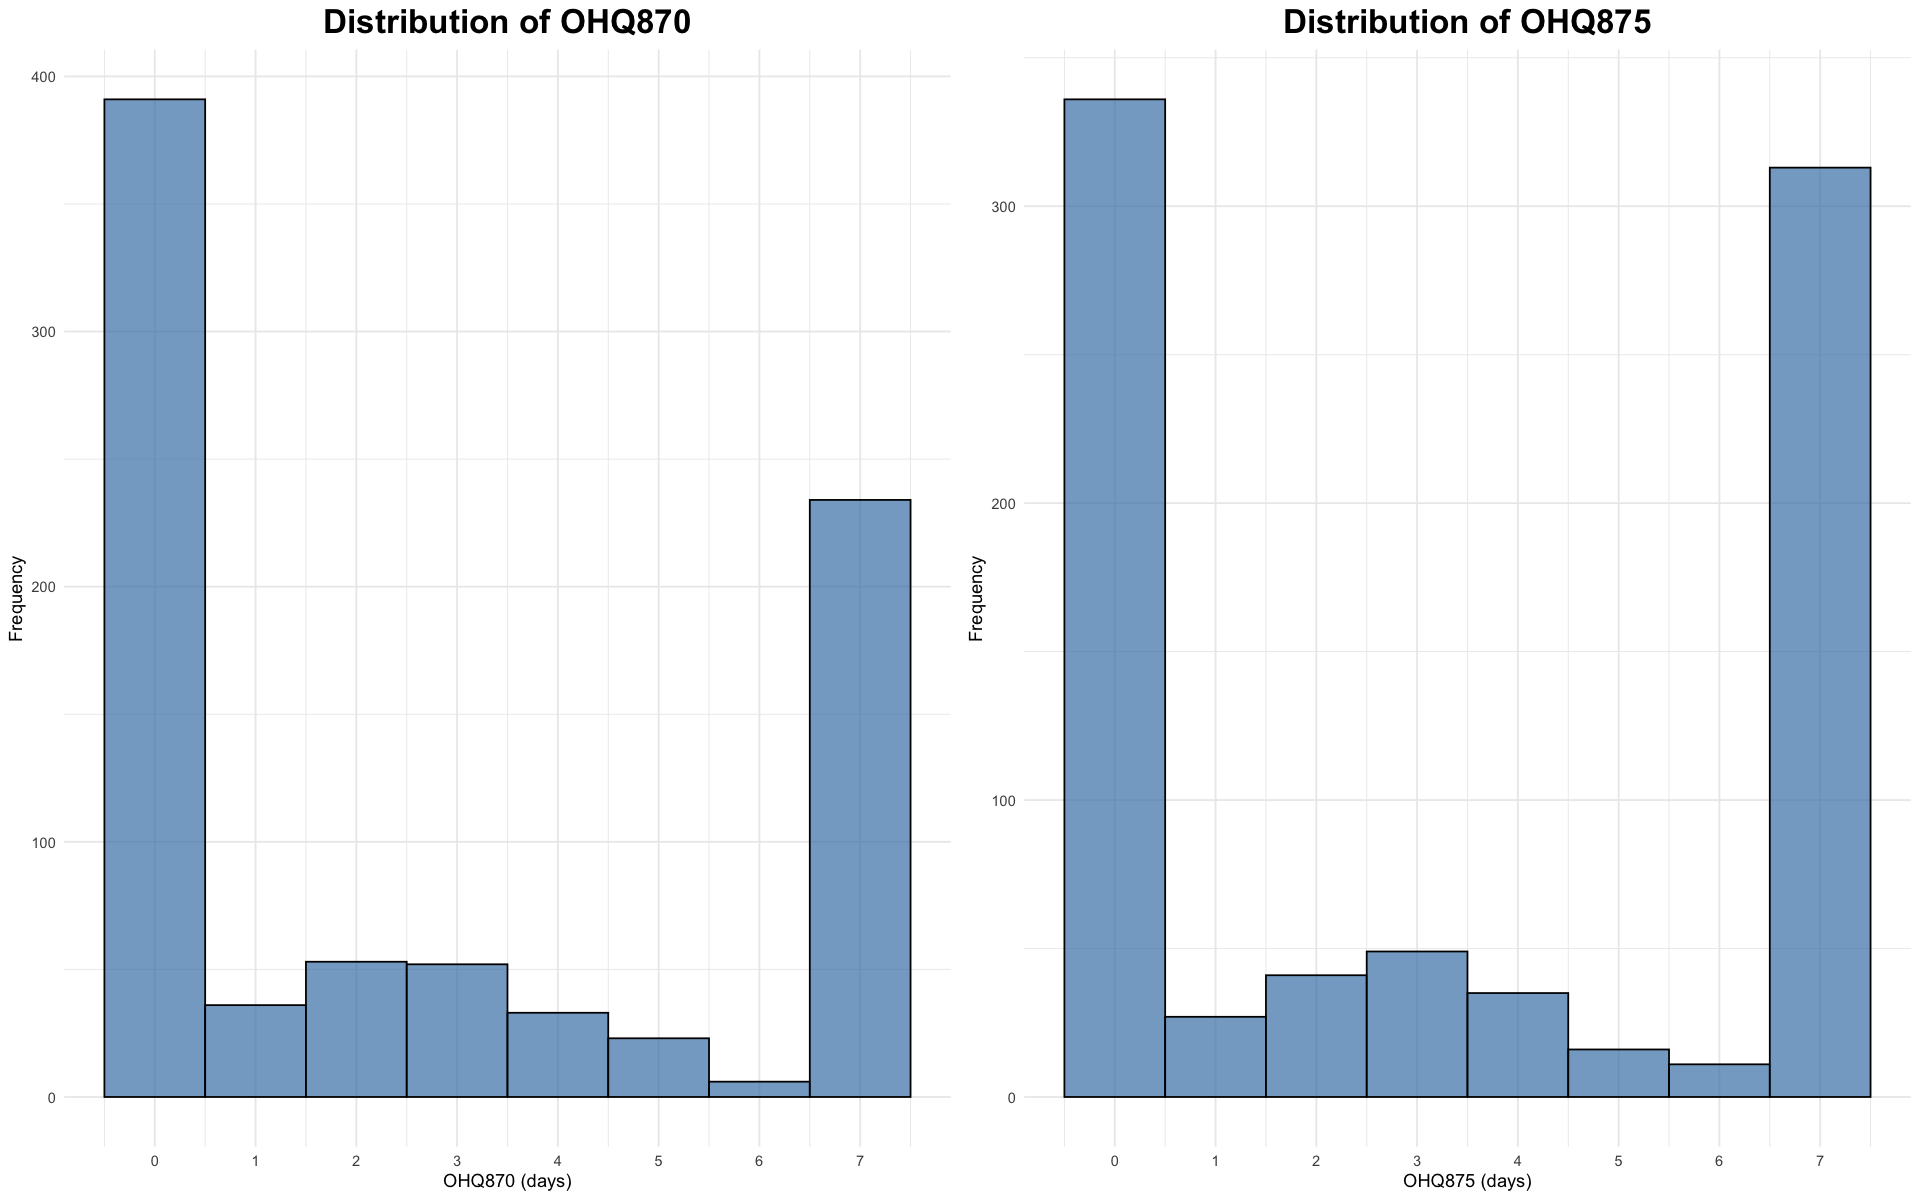

In [54]:
# Histograms for numerical variables

numeric_vars <- c("OHQ870", "OHQ875")
plots_numeric <- list()

for(var in numeric_vars) {
  p <- ggplot(df_oral, aes_string(x = var)) +
    geom_histogram(bins = 8, fill = "steelblue", alpha = 0.7, color = "black") +
    labs(title = paste("Distribution of", var),
         x = paste(var, "(days)"),
         y = "Frequency") +
    theme_minimal() +
    scale_x_continuous(breaks = 0:7) +
    theme(
    plot.title = element_text(hjust = 0.5, face = "bold", size = 20),
    legend.position = "none"
    )
  
  plots_numeric[[var]] <- p
}

grid.arrange(grobs = plots_numeric, ncol = 2)

#### Correlation analysis

In [78]:
# Pre-processing

oral_vars <- c("OHQ835", "OHQ845", "OHQ850", "OHQ855", 
               "OHQ860", "OHQ865", "OHQ870", "OHQ875")

df_oral <- df[, oral_vars]

binary_vars <- c("OHQ835", "OHQ850", "OHQ855", "OHQ860", "OHQ865")
df_oral[binary_vars] <- lapply(df_oral[binary_vars], as.factor)
df_oral[binary_vars] <- lapply(df_oral[binary_vars], as.numeric)

df_oral$OHQ845 <- as.numeric(factor(df_oral$OHQ845, 
                         levels = c(1,2,3,4,5),
                         ordered = TRUE))

head(df_oral)

,OHQ835,OHQ845,OHQ850,OHQ855,OHQ860,OHQ865,OHQ870,OHQ875
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>
1,2,2,2,2,2,2,5,6
2,2,2,1,2,1,2,7,7
3,2,3,2,2,1,1,7,0
4,2,3,2,2,2,2,7,0
5,2,2,2,2,2,2,4,6
6,2,2,2,1,2,2,0,7


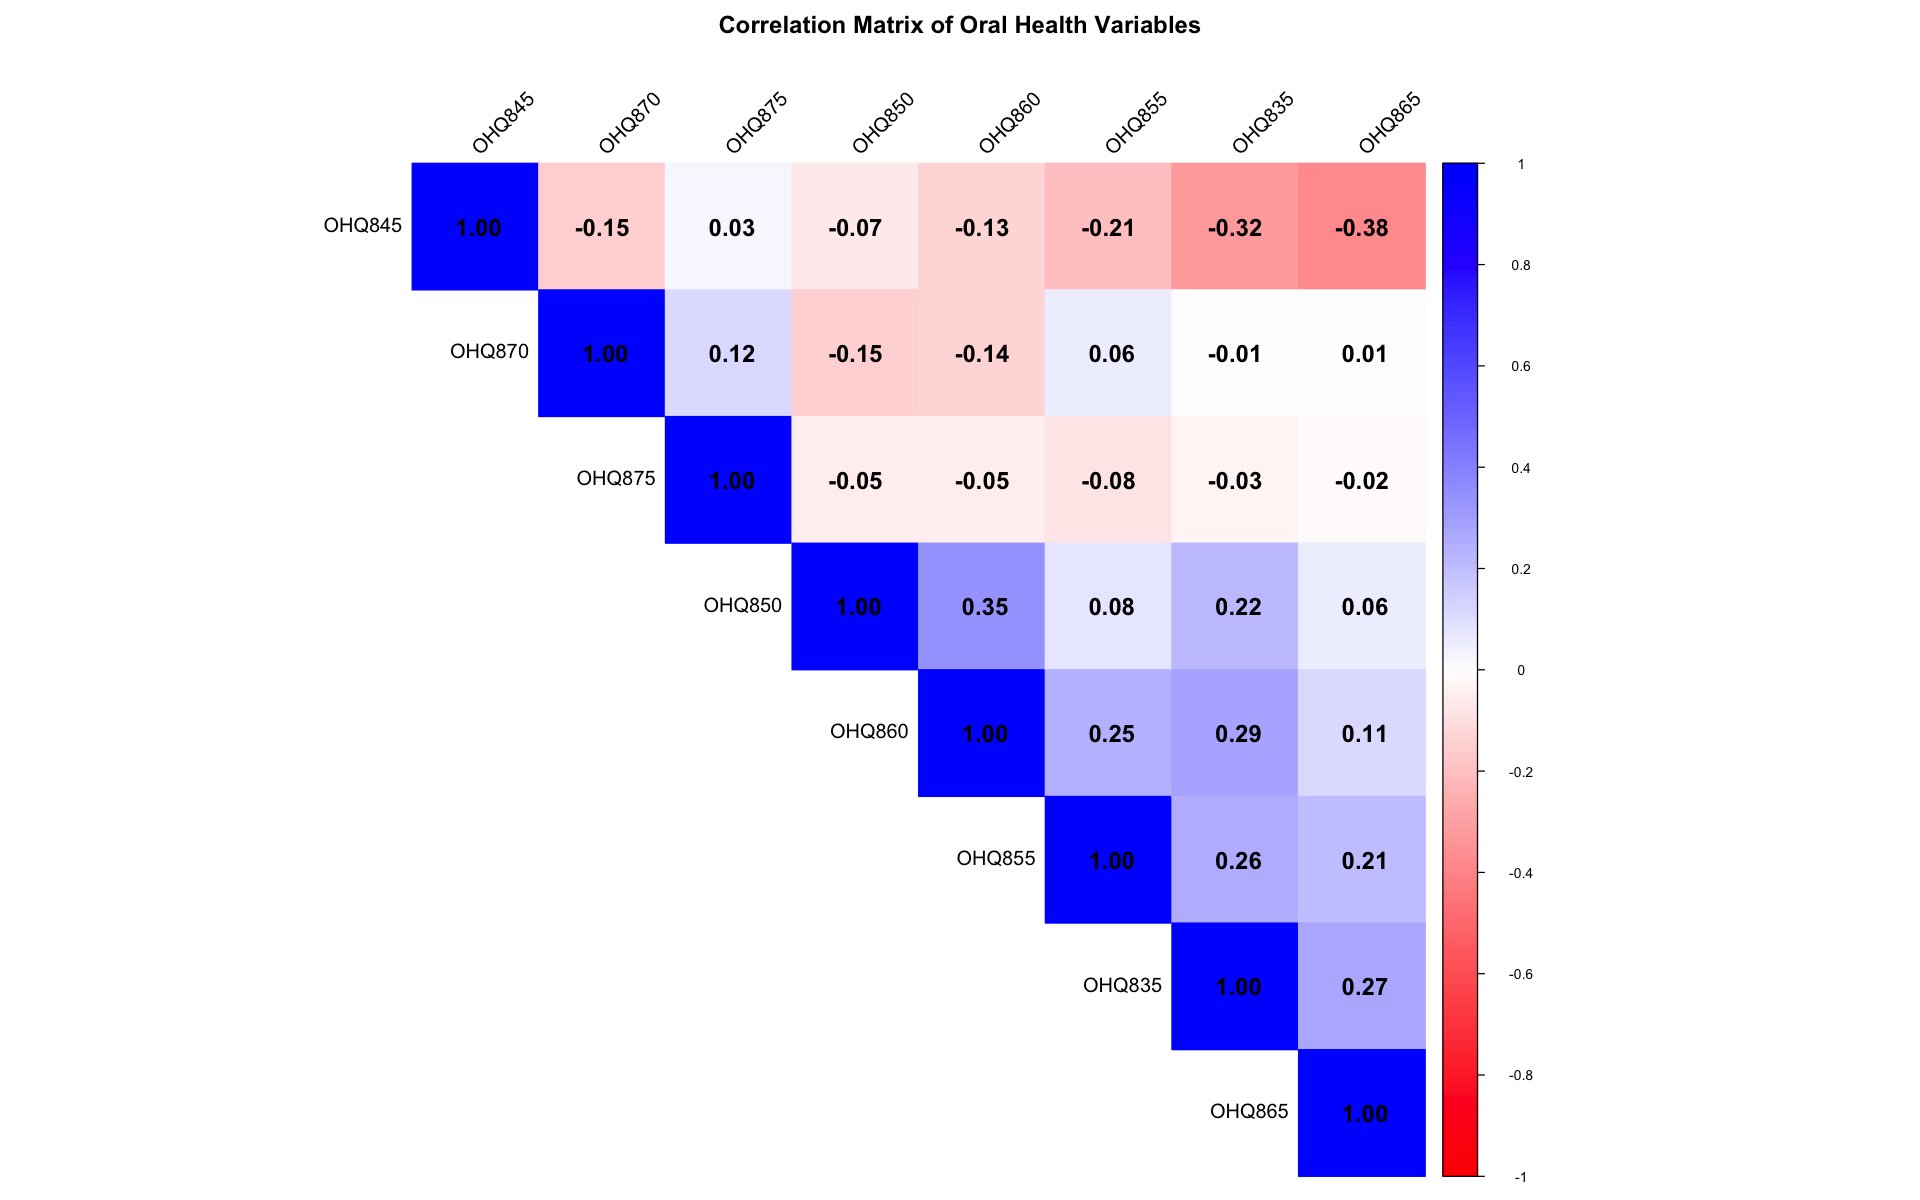

In [96]:
# Correlation matrix

cor_matrix <- cor(df_oral, use = "pairwise.complete.obs")

par(bg = "white")
options(repr.plot.width = 16, repr.plot.height = 10)
corrplot(cor_matrix,
         method = "color",
         type = "upper",
         order = "hclust",
         addCoef.col = "black",
         tl.col = "black",
         tl.srt = 45,
         diag = TRUE,
         number.cex = 1.2,
         col = colorRampPalette(c("red", "white", "blue"))(200),
         cl.cex = 0.7,
         mar = c(0, 0, 2, 0),
         title = "Correlation Matrix of Oral Health Variables"
)

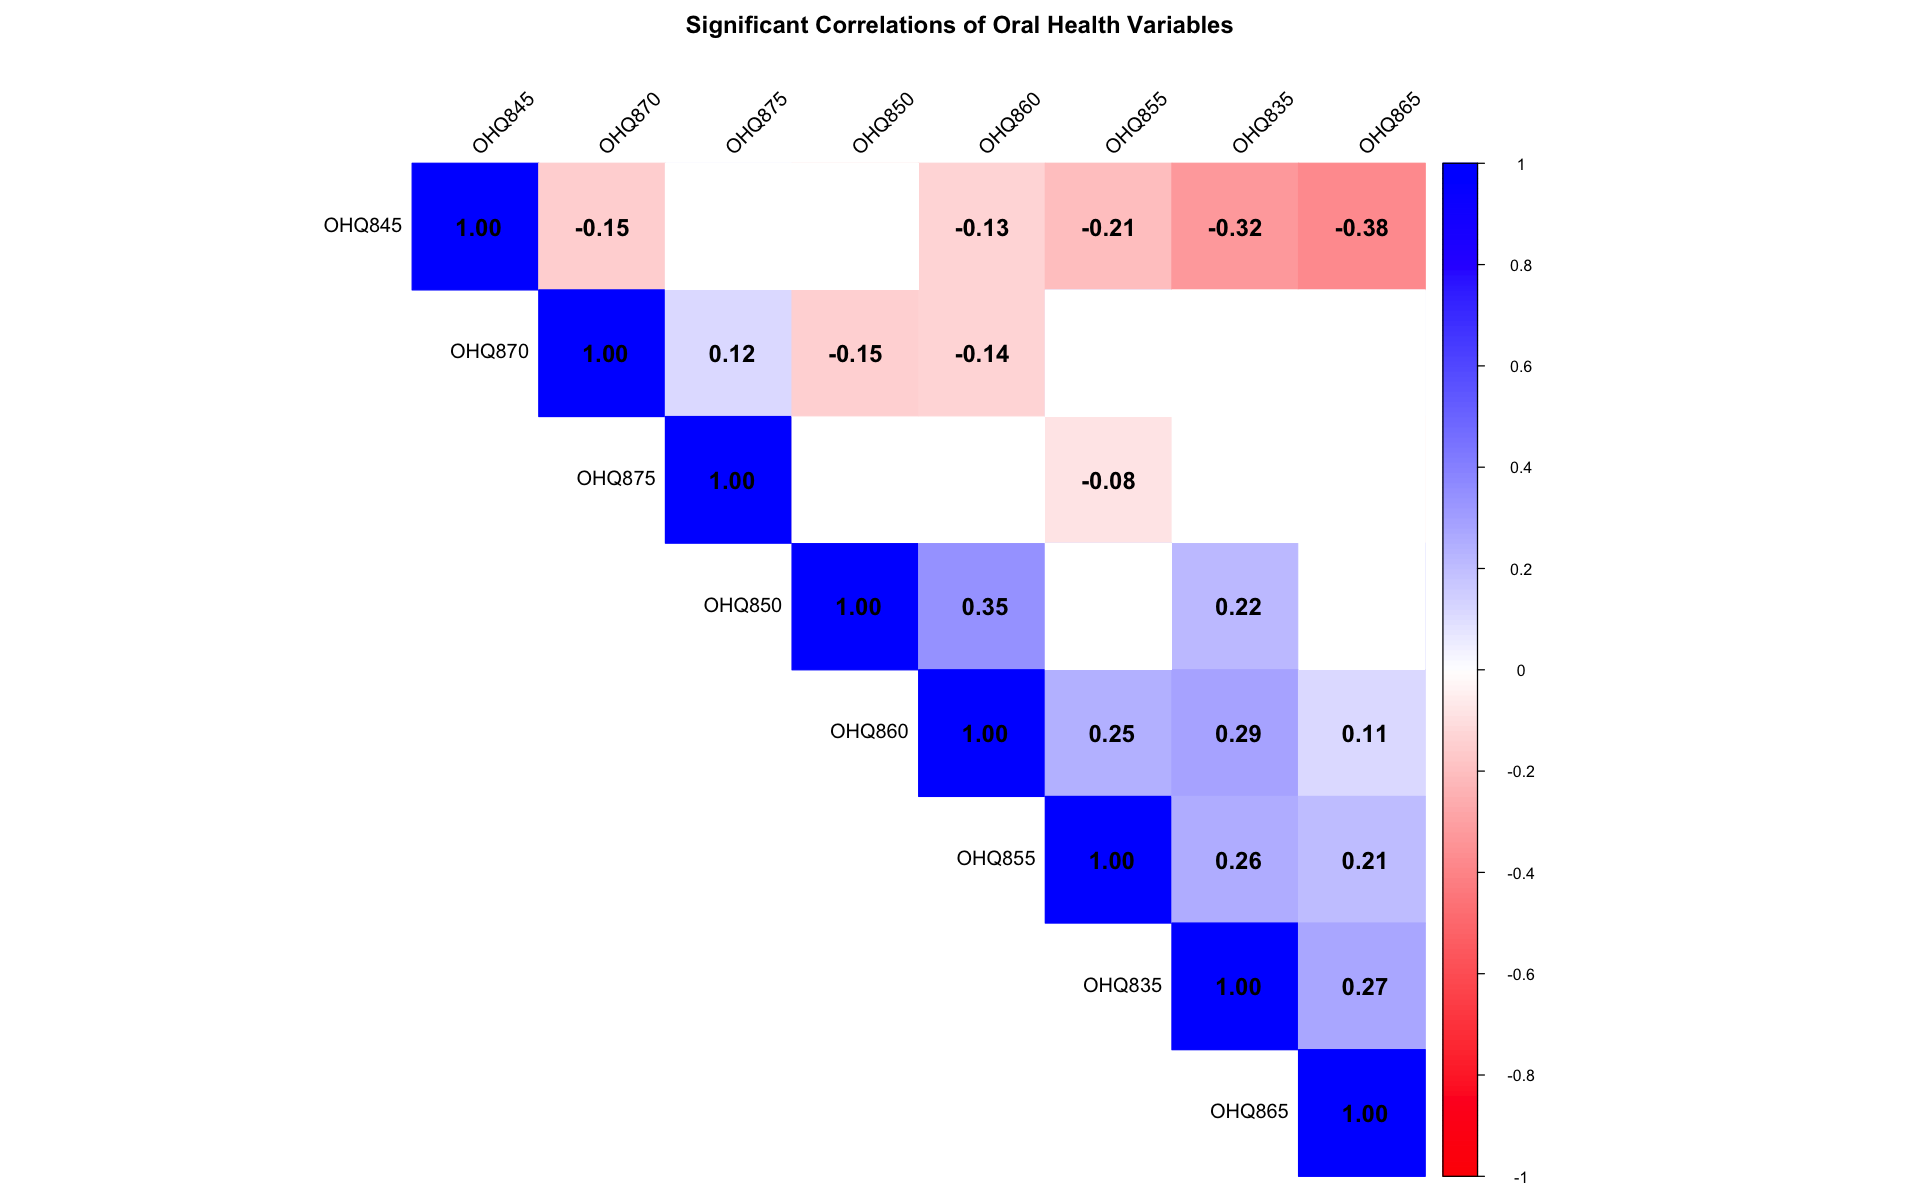

In [94]:
# Significance test of correlations

cor_test_results <- corr.test(df_oral)
cor_matrix <- cor_test_results$r
p_matrix <- cor_test_results$p

par(bg = "white")
corrplot(cor_matrix,
         method = "color",
         type = "upper",
         order = "hclust",
         addCoef.col = "black",
         tl.col = "black",
         tl.srt = 45,
         p.mat = p_matrix,        # ADD p-values matrix
         sig.level = 0.05,         # Only show significant ones
         insig = "blank",          # Blank out non-significant correlations
         number.cex = 1.2,
         col = colorRampPalette(c("red", "white", "blue"))(200),
         title = "Significant Correlations of Oral Health Variables",
         mar = c(0,0,2,0)
)


#### Principal component analysis (PCA)

In [97]:
# Pre-processing

oral_vars <- c("OHQ835", "OHQ845", "OHQ850", "OHQ855", 
               "OHQ860", "OHQ865", "OHQ870", "OHQ875")

df_oral <- df[, oral_vars]

binary_vars <- c("OHQ835", "OHQ850", "OHQ855", "OHQ860", "OHQ865")
df_oral[binary_vars] <- lapply(df_oral[binary_vars], as.factor)
df_oral[binary_vars] <- lapply(df_oral[binary_vars], as.numeric)

df_oral$OHQ845 <- as.numeric(factor(df_oral$OHQ845, 
                         levels = c(1,2,3,4,5),
                         ordered = TRUE))

head(df_oral)

,OHQ835,OHQ845,OHQ850,OHQ855,OHQ860,OHQ865,OHQ870,OHQ875
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>
1,2,2,2,2,2,2,5,6
2,2,2,1,2,1,2,7,7
3,2,3,2,2,1,1,7,0
4,2,3,2,2,2,2,7,0
5,2,2,2,2,2,2,4,6
6,2,2,2,1,2,2,0,7


In [100]:
# Run PCA

pca_result <- prcomp(df_oral, 
                     scale = T,
                     center = T)
summary(pca_result)

Importance of components:
                          PC1    PC2    PC3    PC4     PC5     PC6     PC7
Standard deviation     1.4484 1.1690 1.0051 0.9443 0.89153 0.81551 0.77876
Proportion of Variance 0.2622 0.1708 0.1263 0.1115 0.09935 0.08313 0.07581
Cumulative Proportion  0.2622 0.4331 0.5593 0.6708 0.77016 0.85329 0.92910
                          PC8
Standard deviation     0.7531
Proportion of Variance 0.0709
Cumulative Proportion  1.0000

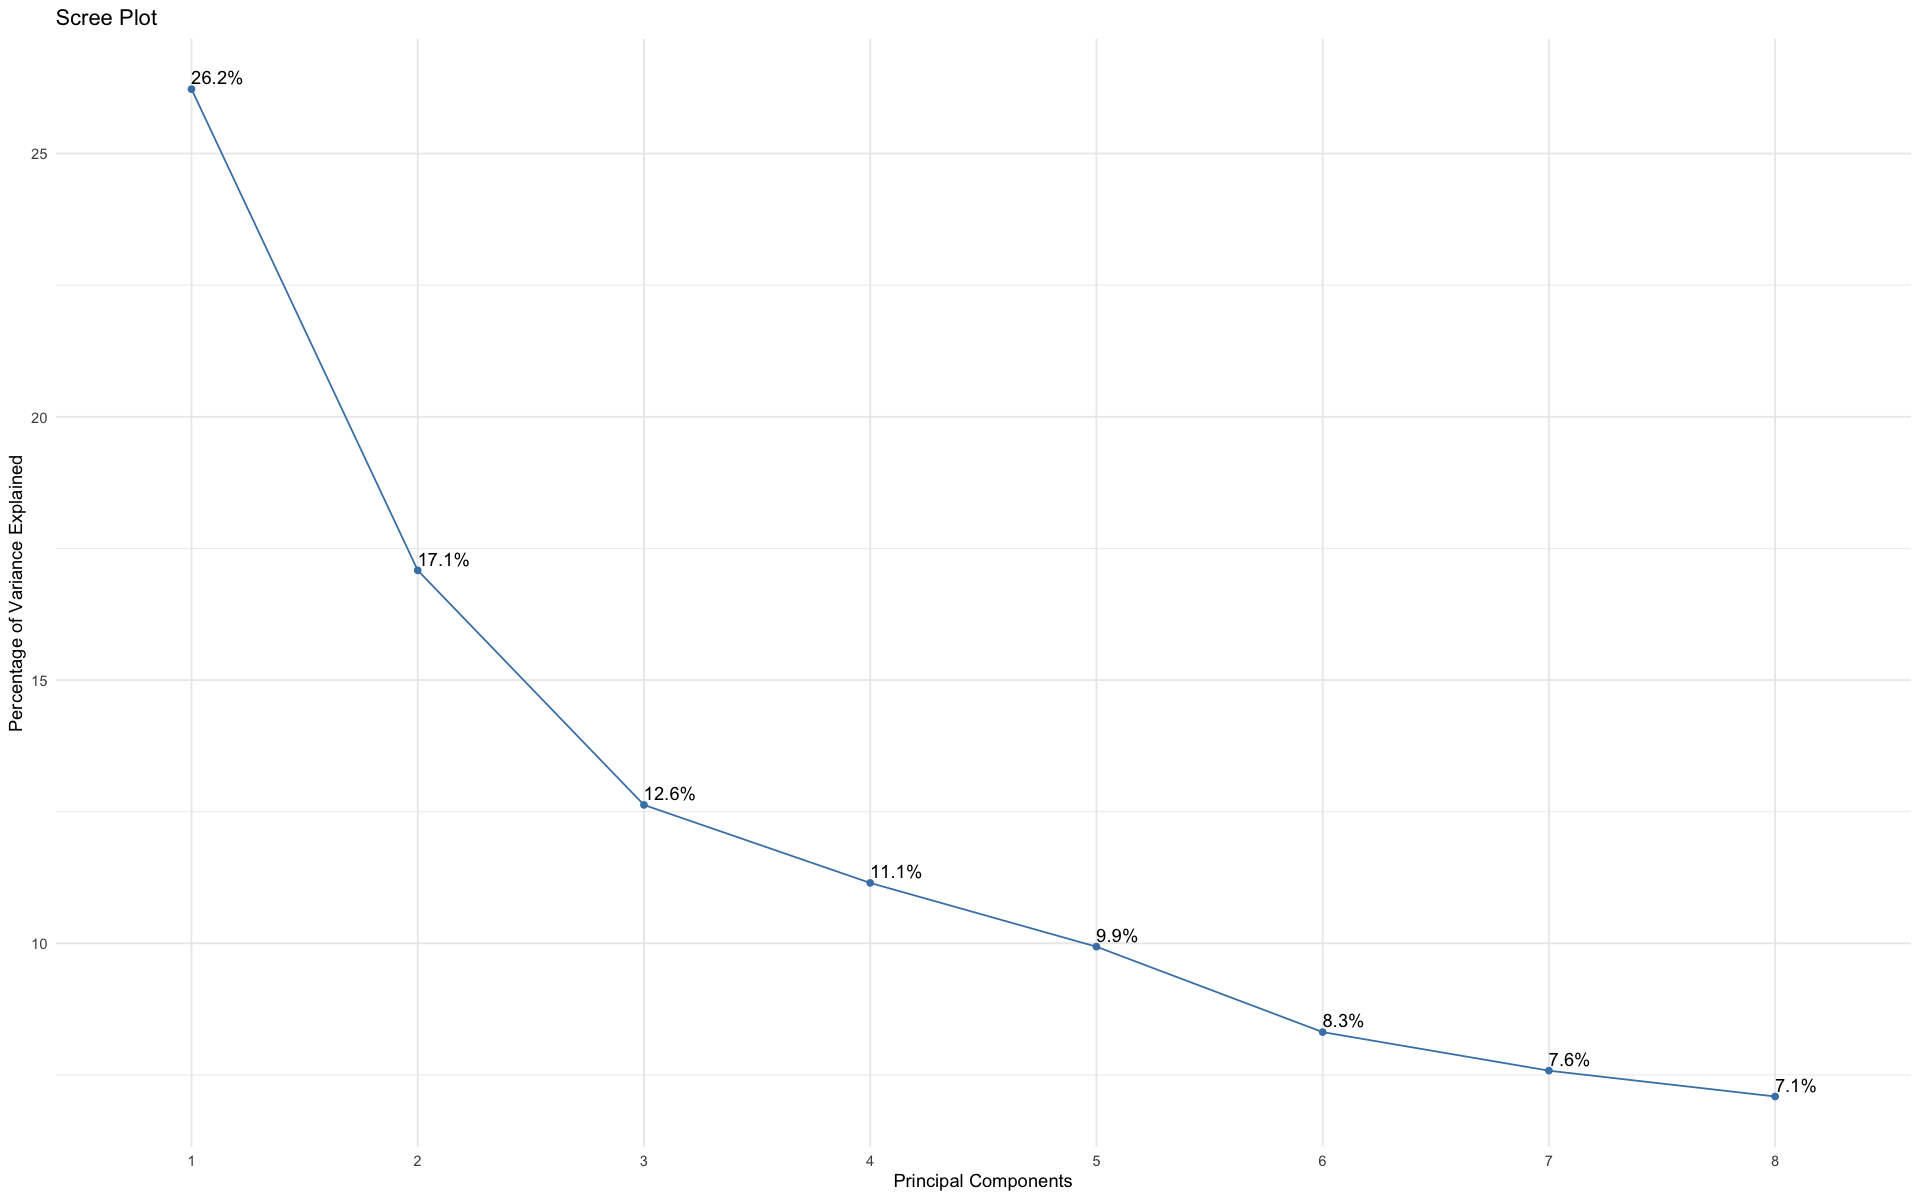

In [103]:
# scree plot

library(factoextra)

fviz_screeplot(pca_result, 
               geom = "line", 
               linecolor = "steelblue", 
               linetype = "solid", 
               addlabels = TRUE) +
  theme_minimal() +
  labs(title = "Scree Plot",
       x = "Principal Components",
       y = "Percentage of Variance Explained")

Warning message:
"Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
i Please use `linewidth` instead."


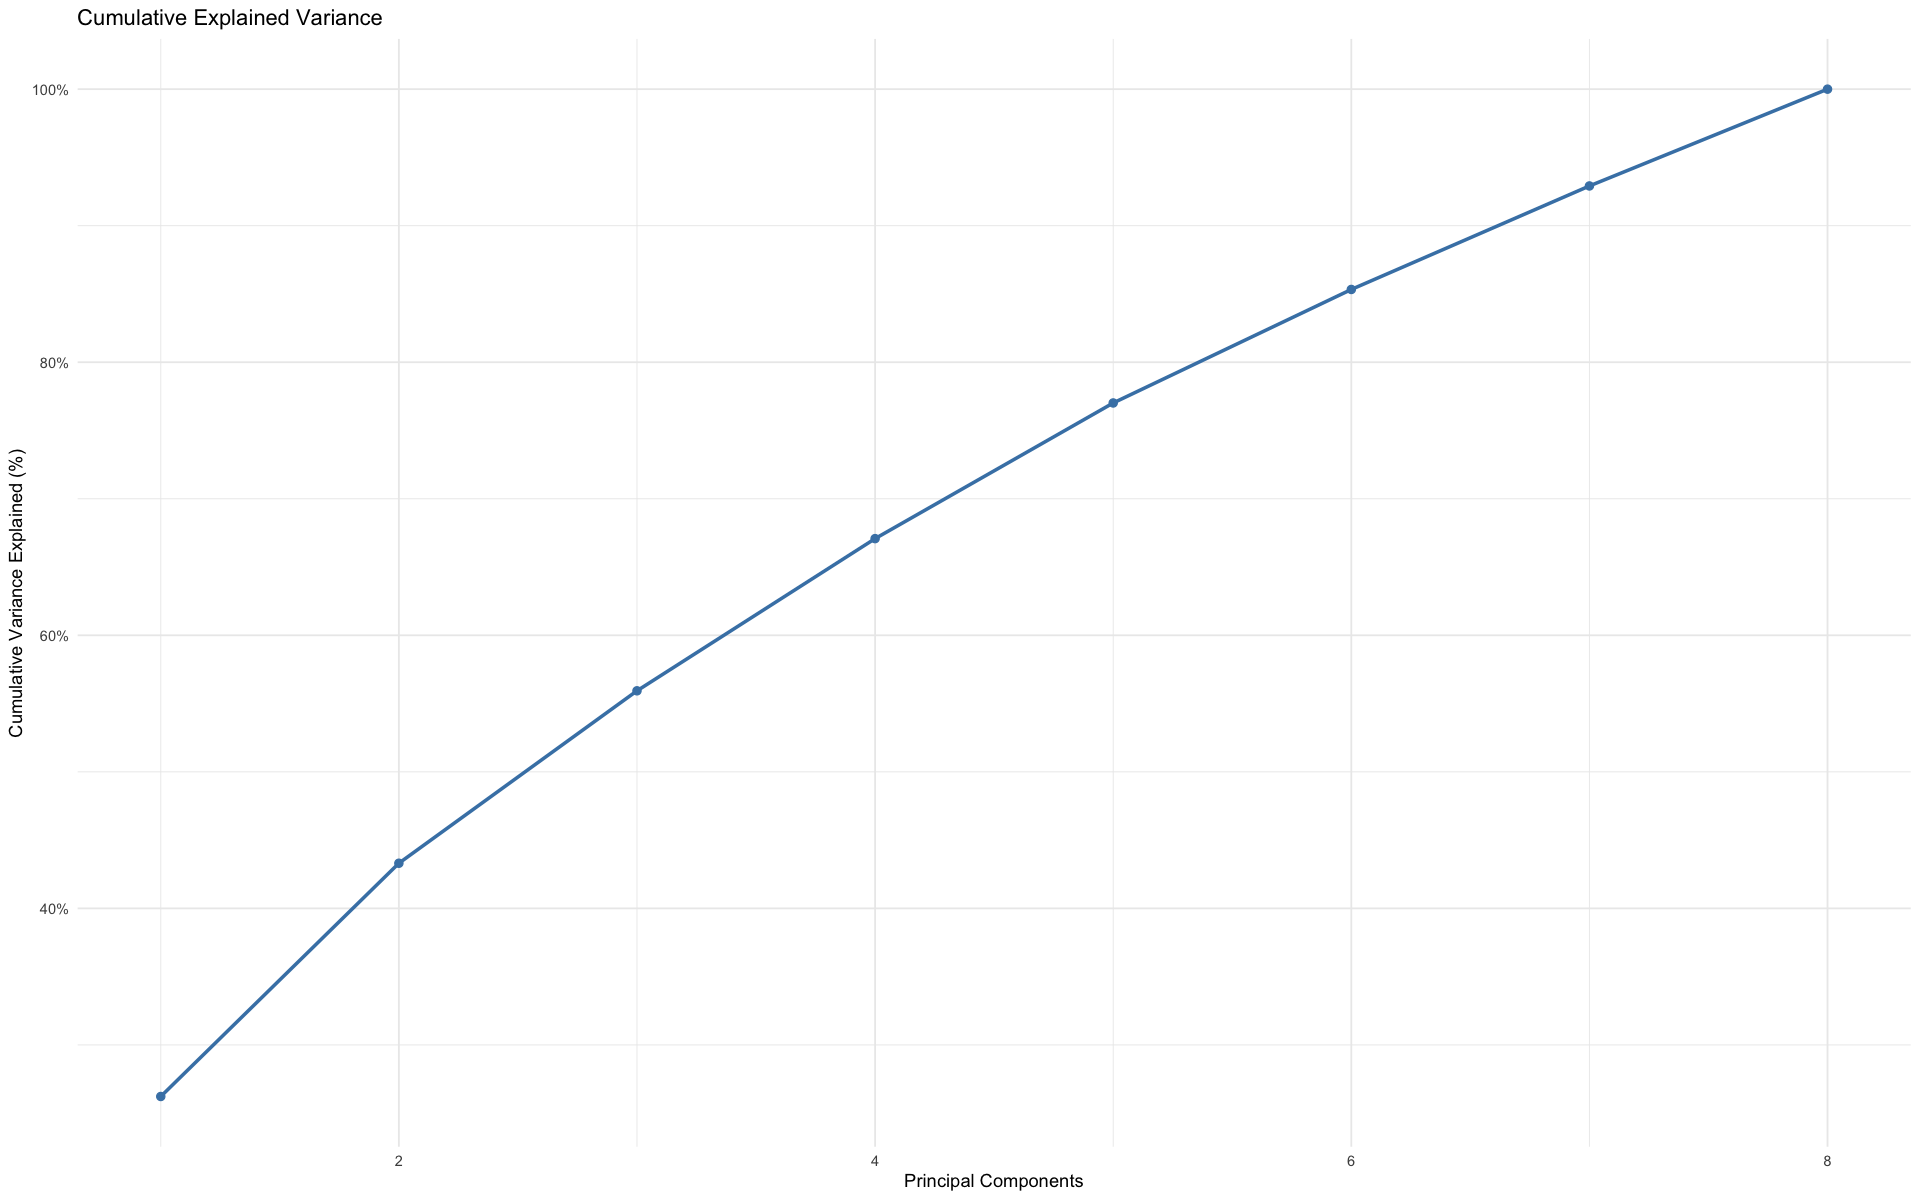

In [105]:
# Plot cumulative explained variance

# Calculate cumulative explained variance
explained_var <- pca_result$sdev^2 / sum(pca_result$sdev^2)
cum_explained_var <- cumsum(explained_var)
cumvar_df <- data.frame(
  PC = seq_along(cum_explained_var),
  CumulativeVariance = cum_explained_var
)

ggplot(cumvar_df, aes(x = PC, y = CumulativeVariance)) +
  geom_line(color = "steelblue", size = 1) +
  geom_point(color = "steelblue", size = 2) +
  scale_y_continuous(labels = scales::percent_format(accuracy = 1)) +
  theme_minimal() +
  labs(title = "Cumulative Explained Variance",
       x = "Principal Components",
       y = "Cumulative Variance Explained (%)")


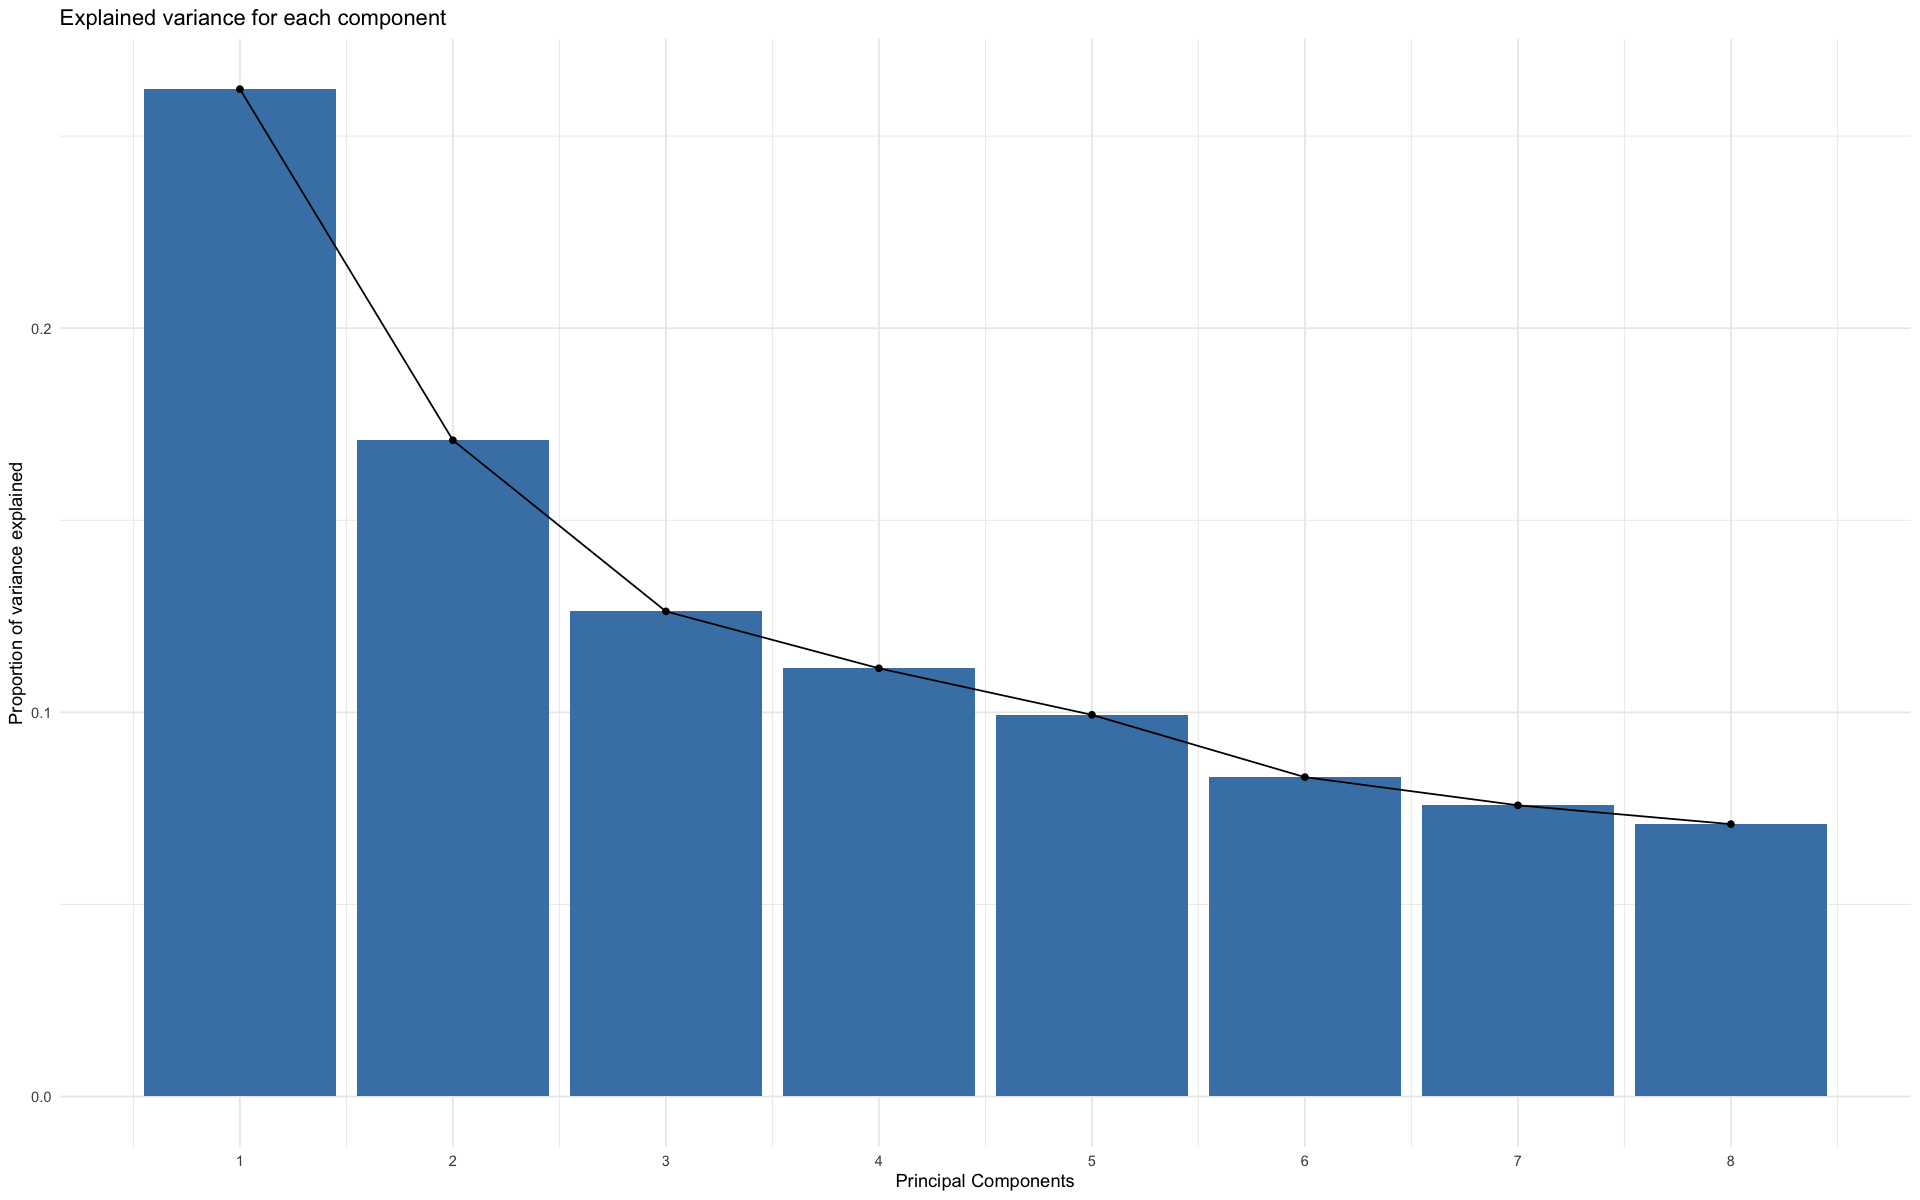

In [106]:
# Display the variance explained

pca_var <- pca_result$sdev^2 / sum(pca_result$sdev^2)
plot_pca_var <- ggplot(data.frame(PC = 1:length(pca_var), Var = pca_var), 
                       aes(x = PC, y = Var)) +
  geom_bar(stat = "identity", fill = "steelblue") +
  geom_line() +
  geom_point() +
  labs(title = "Explained variance for each component",
       x = "Principal Components",
       y = "Proportion of variance explained") +
  theme_minimal() +
  scale_x_continuous(breaks = 1:length(pca_var))

print(plot_pca_var)


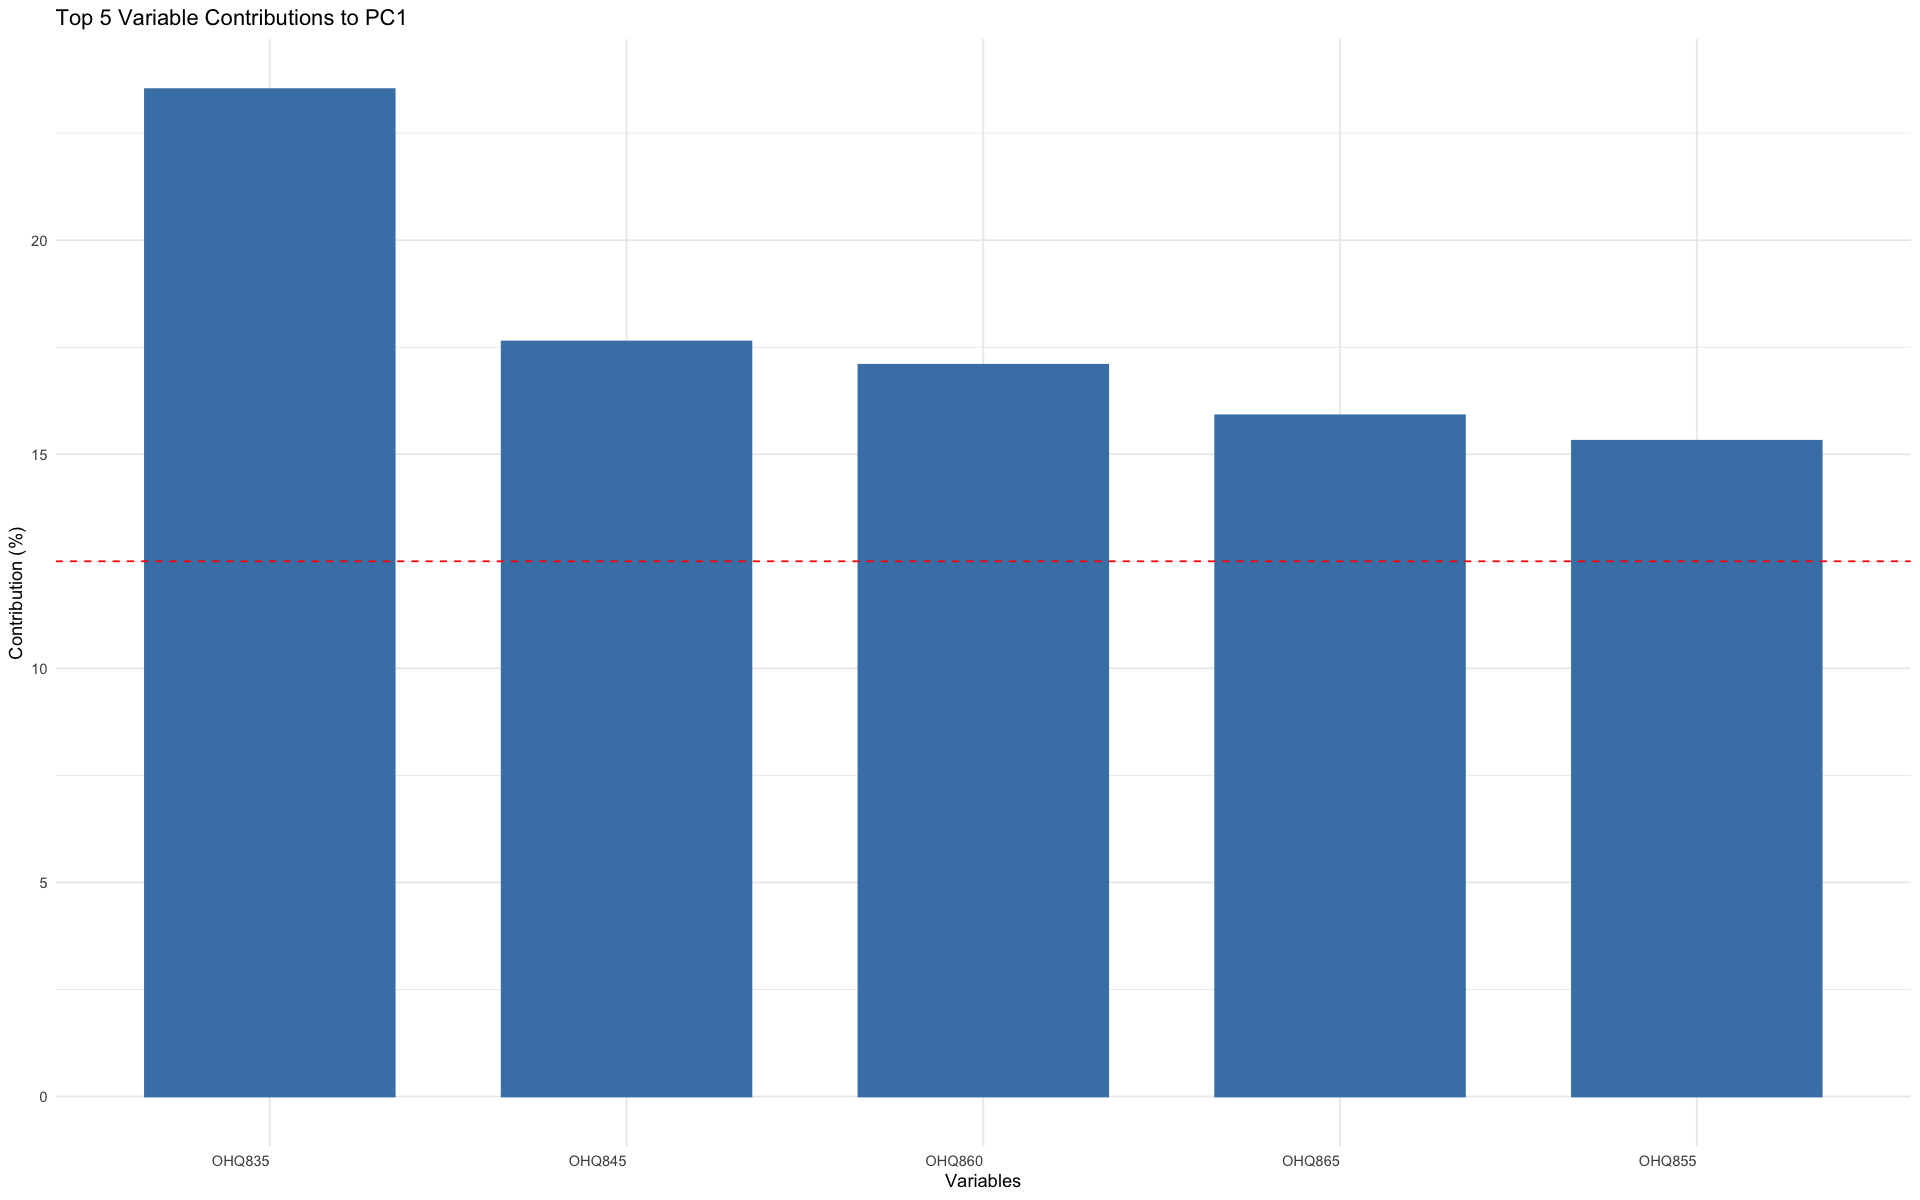

In [ ]:
# Plot top variable contributions to PC1

fviz_contrib(pca_result, 
             choice = "var", 
             axes = 1, 
             top = 5, 
             fill = "steelblue", 
             color = "steelblue") +
  theme_minimal() +
  labs(title = "Top 5 Variable Contributions to PC1",
       x = "Variables",
       y = "Contribution (%)") +
  theme(axis.text.x = element_text(angle = 0, hjust = 1))

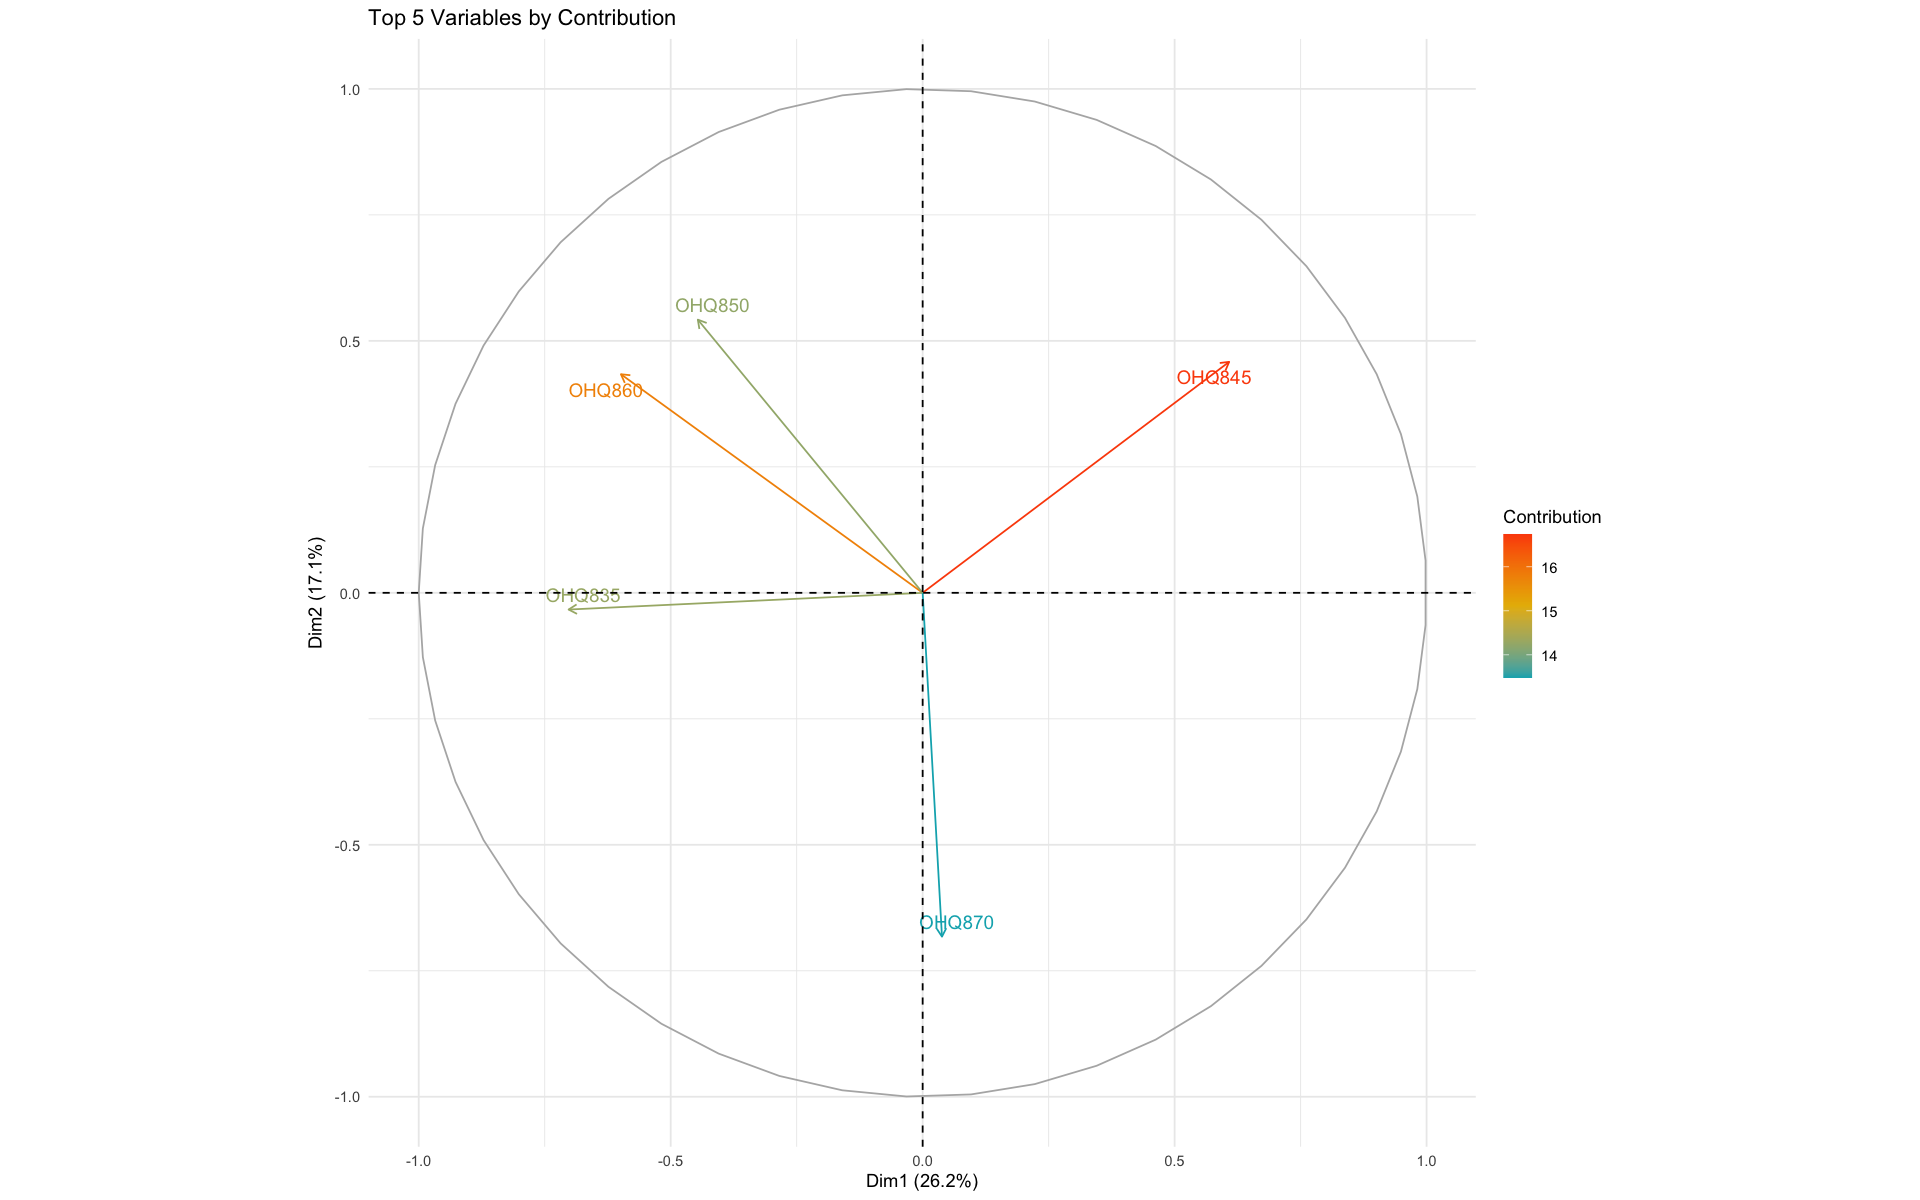

In [111]:
# PCA variable plot - top 10 contributing variables

fviz_pca_var(pca_result, 
             col.var = "contrib", 
             select.var = list(contrib = 5), 
             gradient.cols = c("#00AFBB", "#E7B800", "#FC4E07"), 
             repel = TRUE) +
  theme_minimal() +
  labs(title = "Top 5 Variables by Contribution",
       color = "Contribution")

#### Exploration of possible groupings - Clustering analysis hierarchical

In [135]:
# Pre-processing

oral_vars <- c("OHQ835", "OHQ845", "OHQ850", "OHQ855", 
               "OHQ860", "OHQ865", "OHQ870", "OHQ875")

df_oral <- df[, oral_vars]

binary_vars <- c("OHQ835", "OHQ850", "OHQ855", "OHQ860", "OHQ865")
df_oral[binary_vars] <- lapply(df_oral[binary_vars], as.factor)
#df_oral[binary_vars] <- lapply(df_oral[binary_vars], as.numeric)

df_oral$OHQ845 <- factor(df_oral$OHQ845, 
                         levels = c(1,2,3,4,5),
                         ordered = TRUE)

head(df_oral)

,OHQ835,OHQ845,OHQ850,OHQ855,OHQ860,OHQ865,OHQ870,OHQ875
,<fct>,<ord>,<fct>,<fct>,<fct>,<fct>,<int>,<int>
1,2,2,2,2,2,2,5,6
2,2,2,1,2,1,2,7,7
3,2,3,2,2,1,1,7,0
4,2,3,2,2,2,2,7,0
5,2,2,2,2,2,2,4,6
6,2,2,2,1,2,2,0,7


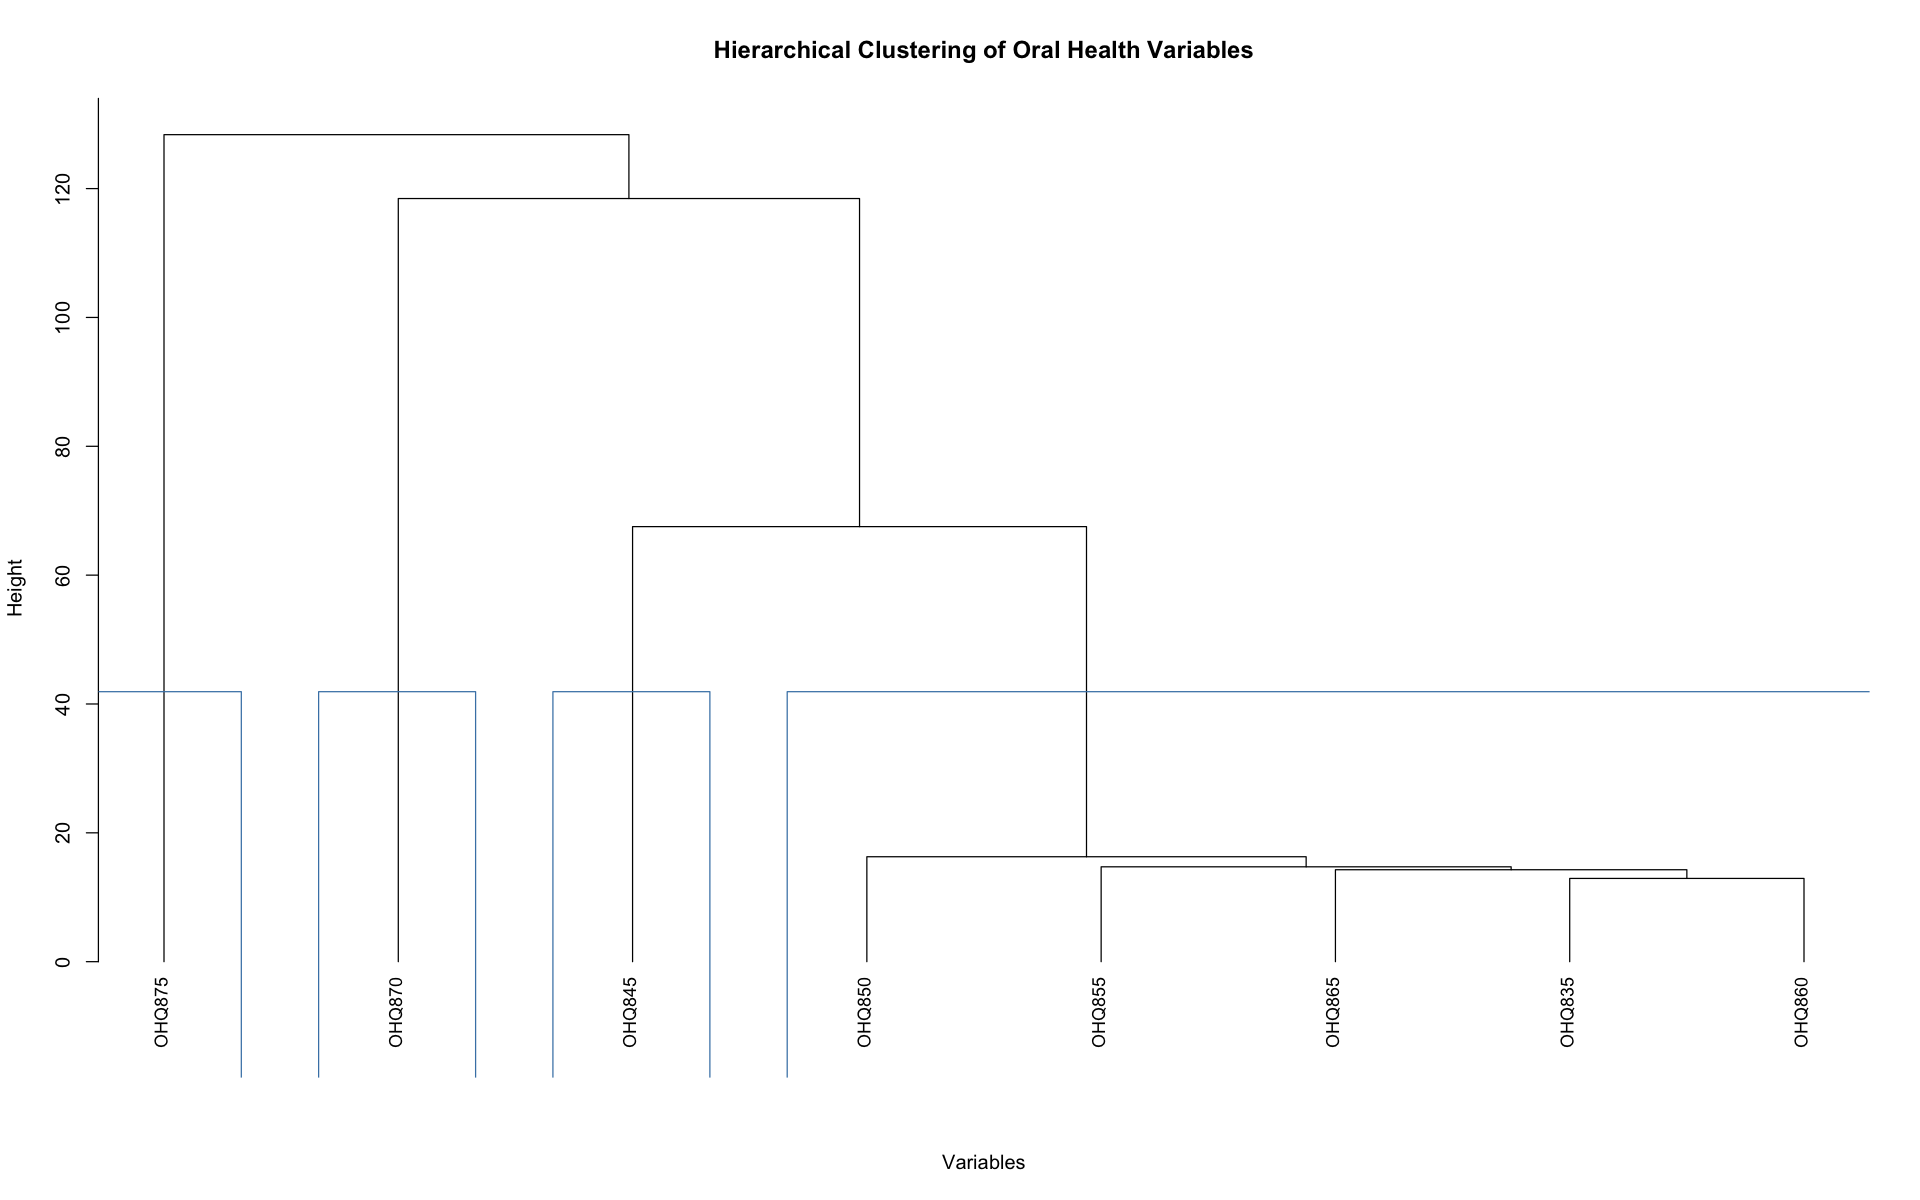

In [136]:
# Perform hierarchical clustering using Ward's method

dist_matrix <- dist(t(df_oral))
hc <- hclust(dist_matrix, method = "ward.D2")

par(bg = "white", mar = c(5, 4, 4, 2) + 0.1)

plot(hc, 
     main = "Hierarchical Clustering of Oral Health Variables",
     xlab = "Variables",
     sub = "",
     cex = 0.9,
     hang = -1,
     labels = colnames(df_oral))

rect.hclust(hc, k = 4, border = "steelblue")

Warning message in wss[k] <- km$withindiff:
"number of items to replace is not a multiple of replacement length"
Warning message in wss[k] <- km$withindiff:
"number of items to replace is not a multiple of replacement length"
Warning message in wss[k] <- km$withindiff:
"number of items to replace is not a multiple of replacement length"
Warning message in wss[k] <- km$withindiff:
"number of items to replace is not a multiple of replacement length"
Warning message in wss[k] <- km$withindiff:
"number of items to replace is not a multiple of replacement length"
Warning message in wss[k] <- km$withindiff:
"number of items to replace is not a multiple of replacement length"
Warning message in wss[k] <- km$withindiff:
"number of items to replace is not a multiple of replacement length"
Warning message in wss[k] <- km$withindiff:
"number of items to replace is not a multiple of replacement length"
Warning message in wss[k] <- km$withindiff:
"number of items to replace is not a multiple of rep

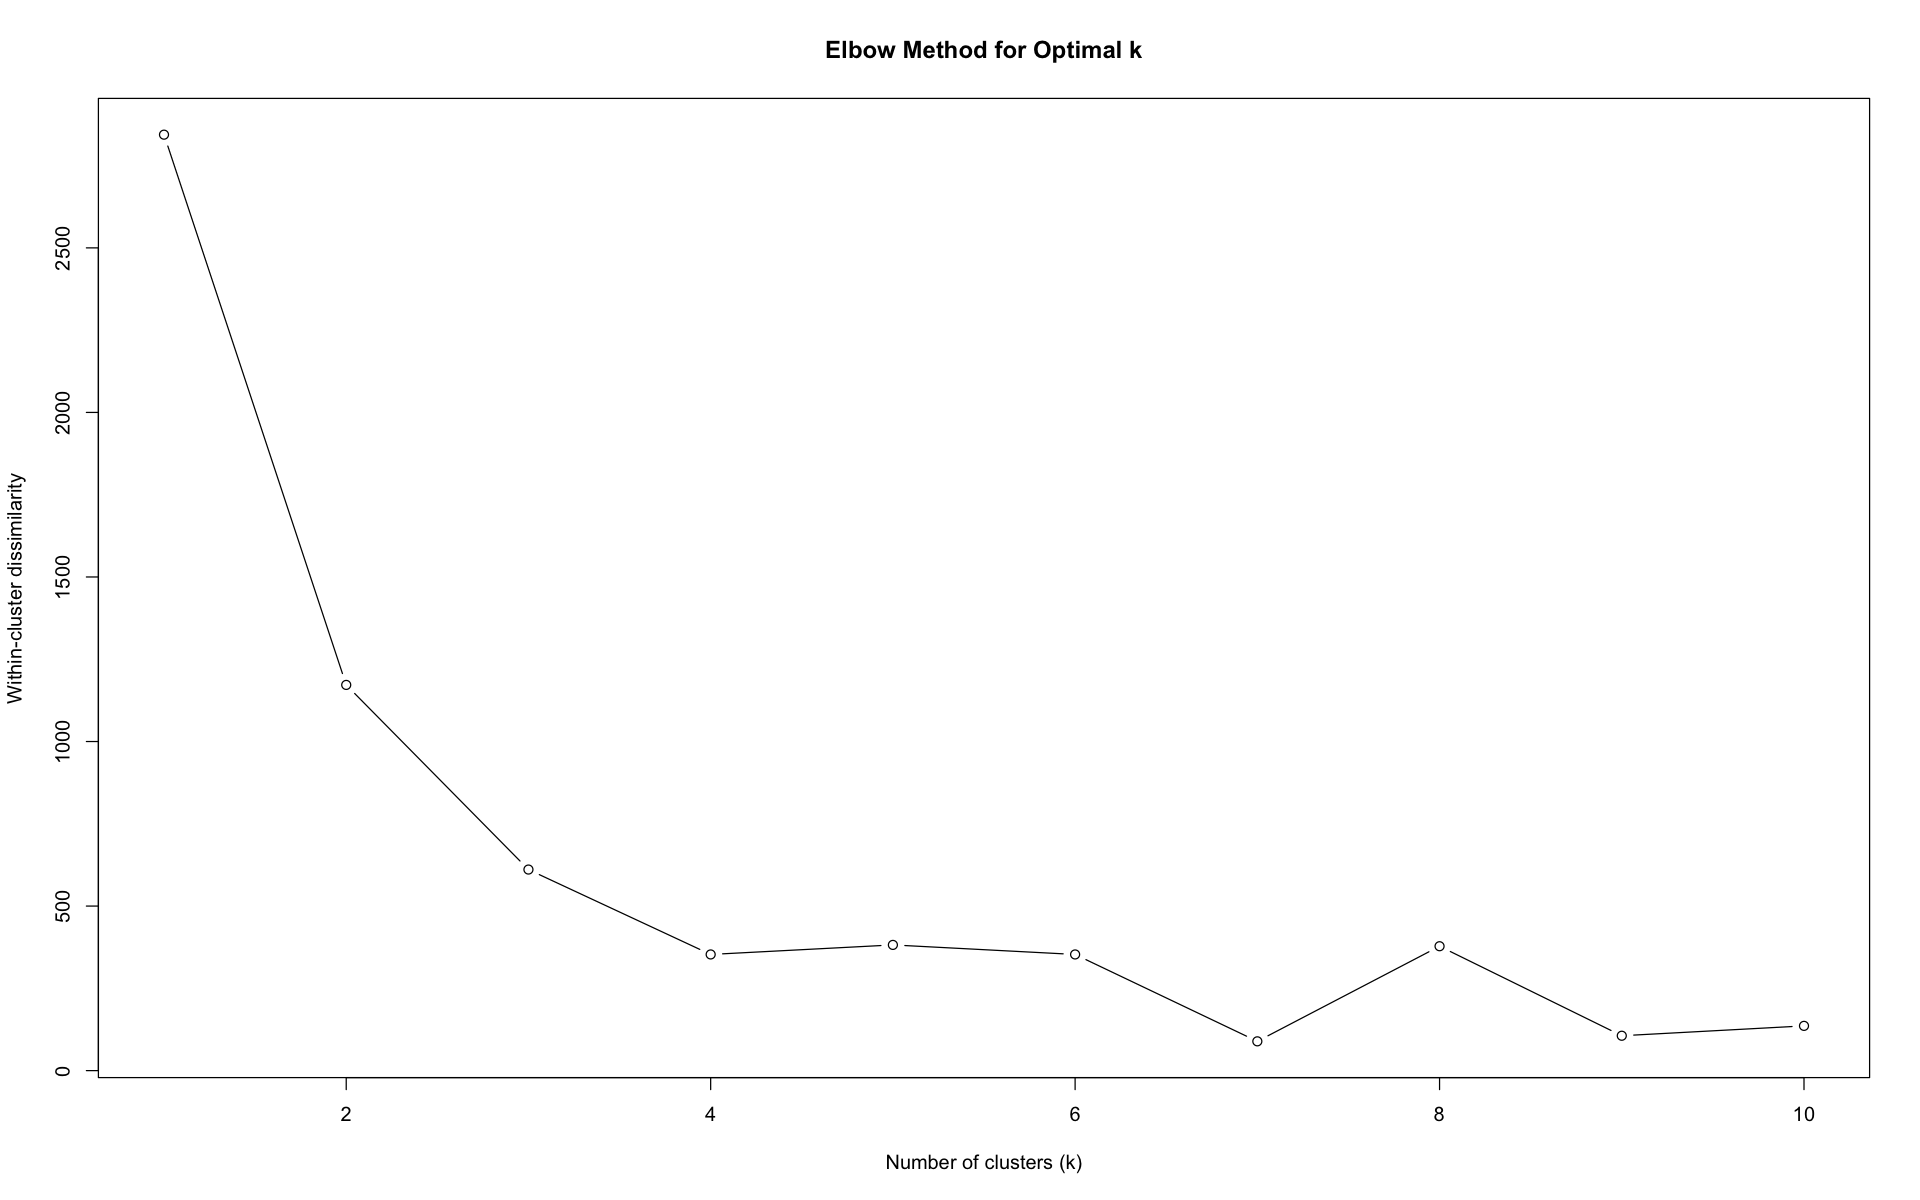

In [ ]:
# Elbow Method for Optimal k

wss <- c()
for (k in 1:10) {
  km <- kmodes(df_cat, modes = k, iter.max = 10)
  wss[k] <- km$withindiff
}

par(bg = "white", mar = c(5, 4, 4, 2) + 0.1)
plot(1:10, wss, type = "b",
     xlab = "Number of clusters (k)",
     ylab = "Within-cluster dissimilarity",
     main = "Elbow Method for Optimal k")


In [ ]:
# K-Modes

install.packages("klaR")
library(klaR)

set.seed(123)
kmodes_result <- kmodes(df_cat, modes = 5, iter.max = 10)

df_cat$cluster <- as.factor(kmodes_result$cluster)


The downloaded binary packages are in
	/var/folders/8d/09j2zdrx7klfl7nffqz630000000gn/T//Rtmpb5Q7lM/downloaded_packages

The downloaded binary packages are in
	/var/folders/8d/09j2zdrx7klfl7nffqz630000000gn/T//Rtmpb5Q7lM/downloaded_packages


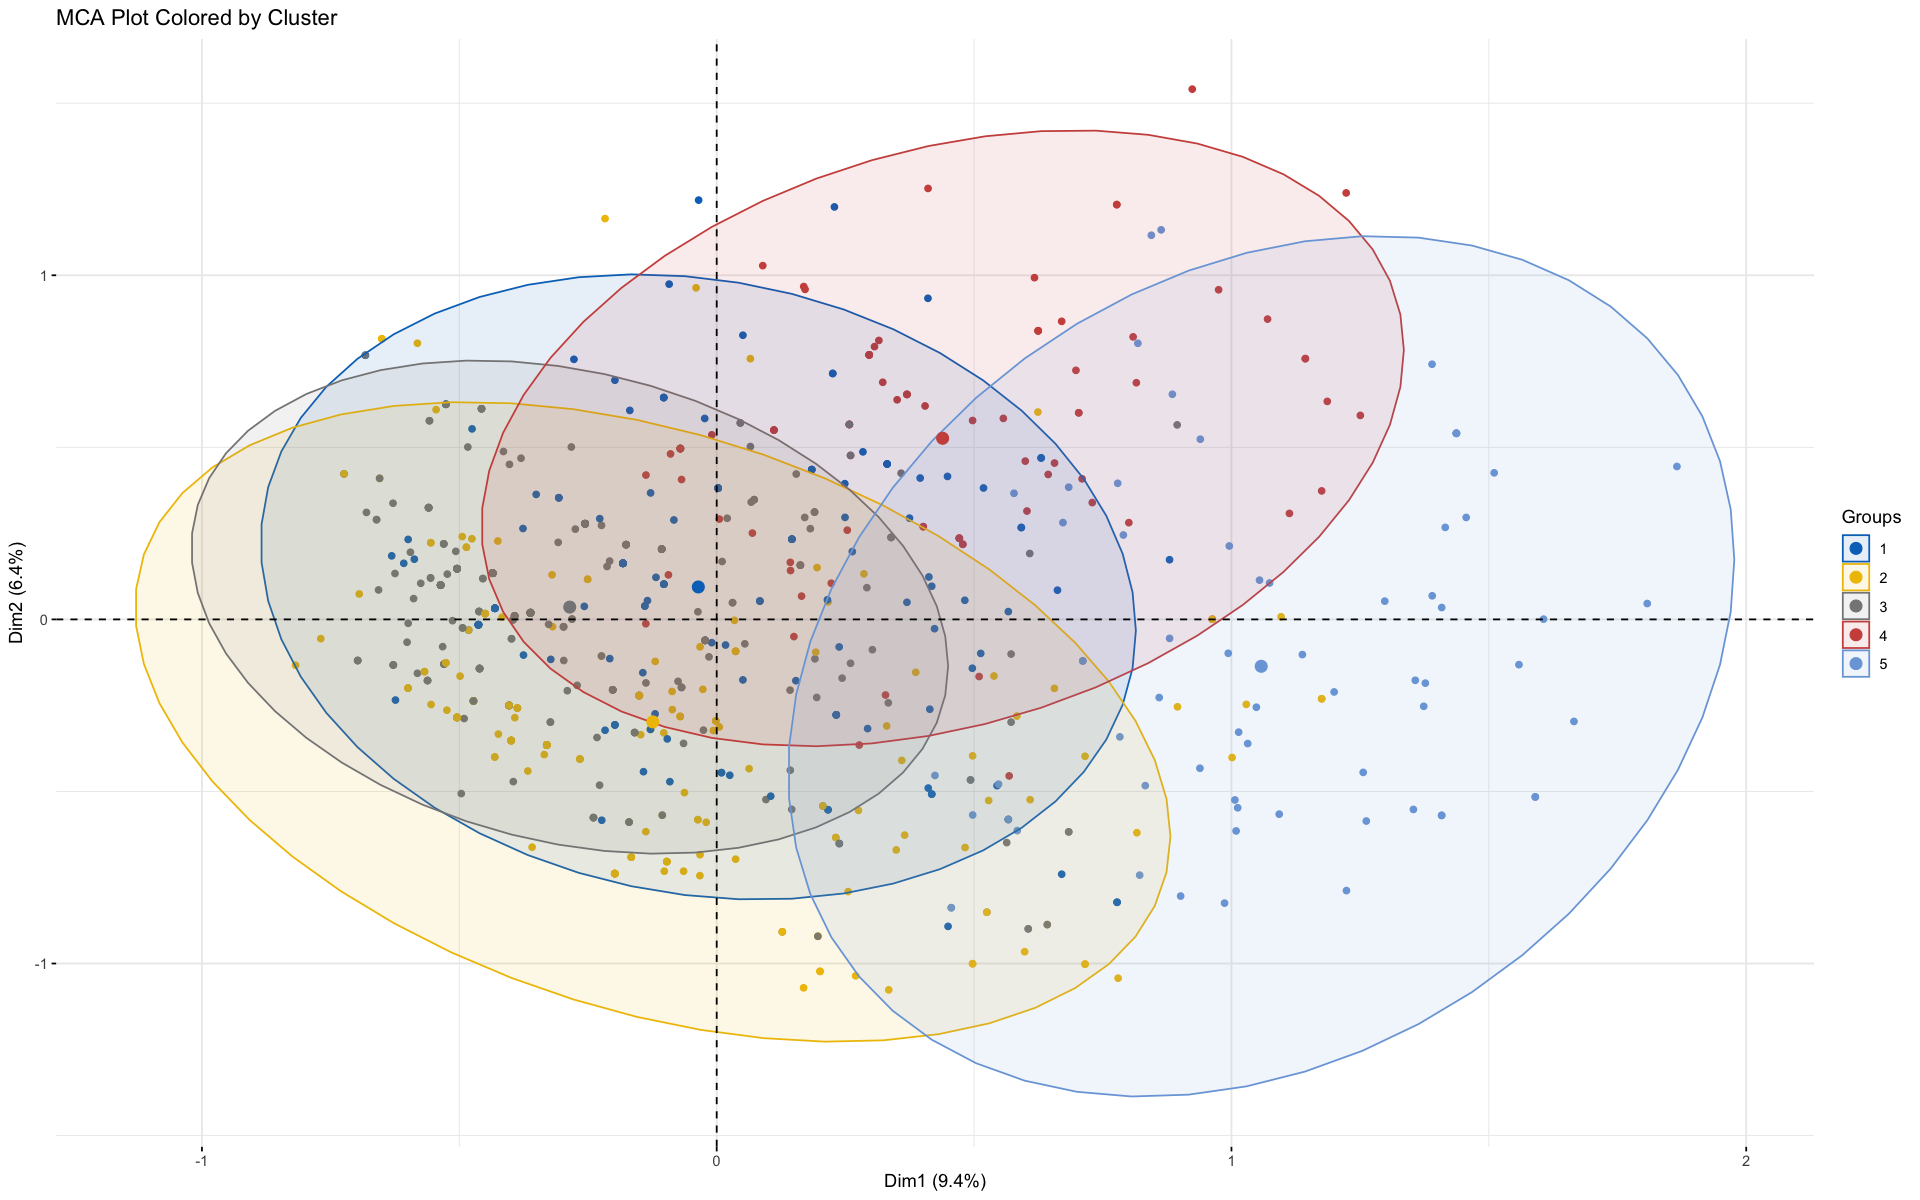

In [ ]:
# Plot with cluster labels

install.packages("FactoMineR")
install.packages("factoextra")
library(FactoMineR)
library(factoextra)

mca_result <- MCA(df_cat[, -ncol(df_cat)], graph = FALSE)

fviz_mca_ind(mca_result, 
             label = "none",
             habillage = df_cat$cluster,
             addEllipses = TRUE,
             palette = "jco") +
  labs(title = "MCA Plot Colored by Cluster")

In [ ]:
# First approach: Binarization of variables

df_binary <- df_oral %>%
  mutate(
    # (1=Yes, 2=No)
    OHQ835_bin = ifelse(OHQ835 == 1, 1, 0),  
    OHQ850_bin = ifelse(OHQ850 == 1, 1, 0),
    OHQ855_bin = ifelse(OHQ855 == 1, 1, 0),
    OHQ860_bin = ifelse(OHQ860 == 1, 1, 0),
    OHQ865_bin = ifelse(OHQ865 == 1, 1, 0),
    
    # Ordinal variable (1-5, where 1 is "Excellent")
    OHQ845_bin = ifelse(OHQ845 >= 4, 0, 1),  
    
    # Continous variables (0-7 days)
    OHQ870_bin = ifelse(OHQ870 >= 3, 1, 0),  # ≥3 days a week = regular usage
    OHQ875_bin = ifelse(OHQ875 >= 3, 1, 0)   # ≥3 days a week = regular usage
  ) %>%
  select(ends_with("_bin"))

### Descriptive Analysis

### Regression Analysis

#### Load Preprocessed Data + Recoded outcome and some variables

#### Bivariate Analysis: Exploratory Data Analysis

#### Crude & Adjusted WHEIGHTED Logistic Regression Analysis